9th december 2020 <br>
02805 Social Graphs and Interactions <br>
This project is made by Signe Nedergaard Mikkelsen, s174306 and Josefine Dyhr Thomsen, s163877. 

Let us start by importing all the necessary packages

In [2]:
import re
import requests
import pandas as pd
import urllib.request
import json
import ssl
import networkx as nx
import io
import os
import matplotlib.pyplot as plt
import community
from operator import itemgetter
from nltk.corpus import stopwords
import nltk
import math
from wordcloud import WordCloud
from statistics import mean
import numpy as np
import collections
from fa2 import ForceAtlas2
import statistics 
from scipy.stats import pearsonr
import matplotlib
import itertools
import pickle
import requests
from tabulate import tabulate
import seaborn as sns

# 1. Motivation

In this project we have chosen to work with animated movies from a broad selection of productions studios. We are both very into animated movies and love watching movies ranging from the good old disney movie "Beauty and the Beast" to the new and modern pixar movie "Onward". Animated movies are often filled with hidden messages and they all have a deeper meaning, that is one of the thing that make animated movies to our favourite movies to watch.  

We wanted to work with reviews of the movies because we think that people are very honest and direct when they are reviewing a movie. So we thought that would make a good foundation for an interesting sentiment analysis and hopefully be very clear which movies are good and which are not. It will be interesting if we can see a connection between the movies either through the division of communities or through the production studio, year of release or budget.

The dataset we are working with during this project is a dataset that we made ourselves. We found all the information needed about each movie on their Wikipedia page. We are downloading movie reviews from the site Rotten Tomatos.


# 2. Basic stats

In this section we would like to show some basic statistics of the data and network and try to get to know the network better. Since we have made our own dataset there is no data cleaning or preprocessing needed. When loading the reviews we are cleaning from stopwords, not english words and signs/emojis.

## 2.1 Dataload
In this section we will load all the data. We will start by loading our own dataset and afterwards load all the movie reviews from Rotten Tomatos. At last we can create our network of animated movies.

### 2.1.1 Dataset

In [106]:
#Importing the data
Data=pd.read_excel('Movie_Data.xlsx',head=True)

In [107]:
Data.head()

Movie                          Production  Year  \
0  Batman: Mask of the Phantasm  Warner Bros. Animation productions  1993   
1                     Space Jam  Warner Bros. Animation productions  1996   
2              Cats Don't Dance  Warner Bros. Animation productions  1997   
3             Quest for Camelot  Warner Bros. Animation productions  1998   
4                The Iron Giant  Warner Bros. Animation productions  1999   

   Budget  Gross  Profit (percent)             RottenTomatoName  
0     6.0    5.8         -3.333333  batman_mask_of_the_phantasm  
1    80.0  230.4        188.000000                    space_jam  
2    32.0    3.6        -88.750000              cats_dont_dance  
3    40.0   38.1         -4.750000            quest_for_camelot  
4    80.0   31.3        -60.875000                   iron_giant

Above the first five rows of our dataset are printed. We have attributes such as the moviename, the production studio, the year the movie was released, the budget in million dollars, the gross in million dollars, the profit in percent and at last the Rotten Tomato moviename. The last attribute will we use when loading the movie reviews from the website Rotten Tomato.

Let us start by displaying some basic stats in our dataset

In [4]:
Data.describe()

Year      Budget        Gross  Profit (percent)
count   221.000000  208.000000   220.000000        208.000000
mean   2000.122172   83.270543   321.160723        829.719343
std      20.666145   59.683933   308.233022       3091.234909
min    1937.000000    0.600000     0.799000        -88.750000
25%    1996.000000   31.750000    79.000000         95.652174
50%    2007.000000   80.000000   248.300000        246.184615
75%    2014.000000  129.000000   484.150000        477.250000
max    2020.000000  260.000000  1657.000000      30993.023256

From the above stats we see that our data contains movies made from year 1937 until today year 2020. The max budget for a film is 260 million dollars which is quite low compared to the max gross of 1657 million dollars, so some movies made a lot of money. 

To get a better idea of data let us have a look at how the movies are distributed in the different production studios.

In [108]:
studio=list(set(list(Data['Production']))) #list of production studios
studiocount=[]
for s in studio:
    studiocount.append(list(Data['Production']).count(s)) #List of number of movies in each production studio

C:\Users\jodth\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.
  """Entry point for launching an IPython kernel.


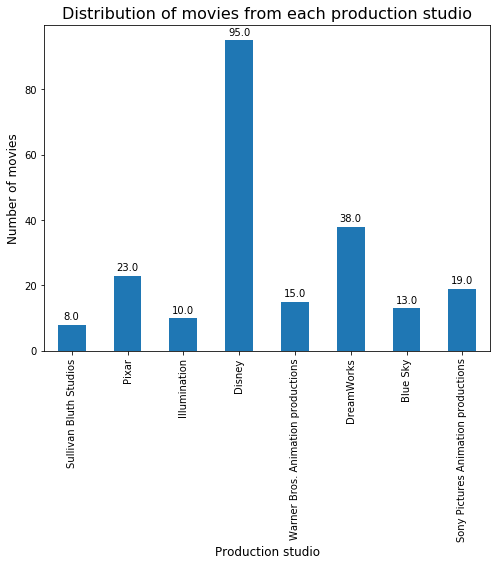

In [110]:
freq_series = pd.Series.from_array(studiocount)

# Plot the figure.
plt.figure(figsize=(8, 6))
ax = freq_series.plot(kind='bar')
ax.set_title('Distribution of movies from each production studio', size=16)
ax.set_xlabel('Production studio',size=12)
ax.set_ylabel('Number of movies',size=12)
ax.set_xticklabels(studio)


def add_value_labels(ax, spacing=3):
    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'
        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'
        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)
        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above
add_value_labels(ax)


From the above distribution we see that the majority of the movies in our dataset is Disney productions, next is DreamWorks and then Pixar. We have to take this into account looking at the network later on.

### 2.1.2 Review load

We define a function **getReviews** that can load a page of movie reviews.

In [7]:
def getReviews(endCursor):
    r = requests.get(f"https://www.rottentomatoes.com/napi/movie/{movieId}/reviews/user",
    params = {
        "direction": "next",
        "endCursor": endCursor,
        "startCursor": ""
    })
    return r.json()

Next the data from the site *Rotten Tomatoes* is extracted and read into a dictionary. The keys in the dictionary is the movie name from our dataframe and the values is a list with all the movie reviews and a list with all the user scores. To minimize the running time we have set an upper bound to 10,000 movie reviews, because we think that 10,000 reviews is enough for the analysis part in this project. There is about 10 reviews on each page in *Rotten Tomatoes* so the code will stop when it has visited 1001 pages or if there is less than 10,000 reviews for a movie. 

In [8]:
ReviewDict={}
k=0
for name in Data.RottenTomatoName.values:
    try:
        print(name)
        r = requests.get("https://www.rottentomatoes.com/m/"+name+"/reviews?type=user") #Define url
        data = json.loads(re.search('movieReview\s=\s(.*);', r.text).group(1)) #Gets the json load
        movieId = data["movieId"] # extract movieID
        reviews = [] #Empty list
        result = {} #Empty Dict
        i=0
        while i != -1: # Running a while loop until there is no more movie reviews or until there reach about 10000 reviews.
            result = getReviews(result["pageInfo"]["endCursor"] if i != 0  else "") #Load the movie reviews into a dict
            i=i+1
            if i==1002: # Check if there is reach 10000 movie reviews
                i=-1
            elif result["pageInfo"]["hasNextPage"] is True: # Check if there is a next page with movie review
                reviews.extend([t for t in result["reviews"]]) # Take out review part of the dict  
            else: # If there is no next page
                i=-1
        moviereview=[] # empty list for movie reviews
        score=[] # empty list for user score
        for j in range(len(reviews)):
            moviereview.extend([reviews[j]['review']]) 
            score.extend([reviews[j]['score']])
        ReviewDict[Data['Movie'][k]]=[moviereview,score] #Enter the movie reviews and score to a dict where the movie name is key
        k=k+1
    except:
        print("ERROR: "+name)
        k=k+1

#### 2.1.2.1 Cleaning of reviews

We have decided on some critias for when a movie review can be a part of this analysis. 
The review most be in english and the review should not be an email adress, url or just emojis. To ensure this we remove all emojis from the review and then check for the email adress, url and only consists of signs. If the review fulfills this, then the review is checked if it is written in english. If the review is in english then the text is cleaned by removing stopwords and the last s, if the words ends with s. That is because we do not want what is basically the same word two times. We know that s also will be removed where it is supposed to be there, but we will just remember that. <br> 
First the *emoji_pattern* is defined to remove emojis from the reviews.

In [194]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [112]:
stop_words = (stopwords.words('english')) #List of stopwords
for name in Data.Movie.values:
    l=[]
    for j in range(0,len(ReviewDict[name][0])): #Loop through movie reviews
        string=ReviewDict[name][0][j] 
        string1=string.replace("\n","") #Remove \n
        string2=string1.replace("\t","") #Remove \t
        string3=emoji_pattern.sub(r'', string2) # Remove emojies
        if len(re.sub(r'^https?:\/\/.*[\r\n]*', '', string3.lower(), flags=re.MULTILINE))!=0 and len(re.findall('[a-z]+', string3.lower(), flags=re.IGNORECASE))>2 and re.search('[^@]+@[^@]+\.[^@]+',string3.lower())==None: # Check if the comment only is URL, signs or email
            if detect(string3)=='en': #Check if the comment is english
                string4=string3.replace("’","") #remove '
                string5=string4.replace("'","")
                string6=re.sub(r'[^\w\s]',' ',string5) # Leaves only words and digits
                words=re.sub(r"(^|\W)\d+", "", string6) #Remove digits
                newWords = [ch1 for ch1 in words.split() if ch1.lower() not in stop_words] #Check for stopwords
                newWords1=[ch[:-1].lower() if ch.endswith('s') else ch.lower() for ch in newWords] #Remove the last 's' in a string
                l.append(newWords1) 
    ReviewDict[name]=[ReviewDict[name][0],ReviewDict[name][1],l] # Add list with clean movie reviews to dict

The dictionary now contains moviename as key and values as list of reviews, list of user score, average user score and cleaned reviews.

### 2.1.3 Creation of network

In this section we will create our network with movienames as nodes and wikipedia links as edges. First we need to load all the wikipedia pages of each movie in our dataset. We are saving the pages in a file on our computer called 'Movie'.

In [5]:
#Loading wikipedia pages and saving them on our computer
baseurl = "https://en.wikipedia.org/w/api.php?"
action = "action=query"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"
folder="Movies"
for MovieName in Data['Movie']:
    try:
        titel=MovieName.replace(" ","_")
        Replace1=titel.replace("/'","%27")
        Replace2=Replace1.replace("&","%26")
        title = f"titles={Replace2}"
        query=("{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat))    
        context=ssl._create_unverified_context()
        response=urllib.request.urlopen(query, context=context)
        source=response.read().decode("utf-8")
        f=json.loads(source)
        data=f['query']['pages'][list(f['query']['pages'].keys())[0]]['revisions'][0]['*']
        Replace3=MovieName.replace(":","")
        filename=f"./{folder}/{Replace3}.txt"
        file=open(f"{filename}","w",encoding='utf-8')
        file.write(data)
        file.close()
    except:
        print(MovieName)

We are removing the colon from the movienames since colon is not aloud in filenames.

In [113]:
Data["Movie"] = Data["Movie"].str.replace(':', '')

Now we can create our network as a directed graph. We are adding each movie as nodes in the network and adding the production studio, the budget and the gross as nodeattributes.

In [114]:
DG = nx.DiGraph()
directory = [r'./Movies/']
for i in range(len(directory)):
    for filename in os.listdir(directory[i]):
        if filename.endswith(".txt"):
            DG.add_node(filename.split(".txt")[0], universe=Data['Production'][list(Data['Movie']).index(filename.split(".txt")[0])],budget=Data['Budget'][list(Data['Movie']).index(filename.split(".txt")[0])],gross=Data['Gross'][list(Data['Movie']).index(filename.split(".txt")[0])]) 

We are adding edges to the network depending on the wikilinks found in each movies wikipedia page.

In [115]:
N=pd.DataFrame(list(DG.nodes),columns=['Nodes'])
for i in range(len(N)):
    node=N["Nodes"][i]   
    f=io.open(f'./Movies/{node}.txt','r',encoding='utf-8')
    links = re.findall(r'\[{2}(.+?)(?=\]{2}|\|(.+?)\])',f.read())
    links = pd.DataFrame(links)
    links = pd.DataFrame(links.values.flatten())
    links = links[links[0]!=""]
    links.columns = ["Nodes"]
    common_links = pd.merge(links, N, how="inner", on = "Nodes")
    links = pd.DataFrame(common_links.groupby("Nodes")["Nodes"].count())

    for i in range(len(links)):
        DG.add_weighted_edges_from([(node, links.index[i], links.iloc[i][0])])

Now we have created our directed network. This will we refer to as DG. Let us try to display the network

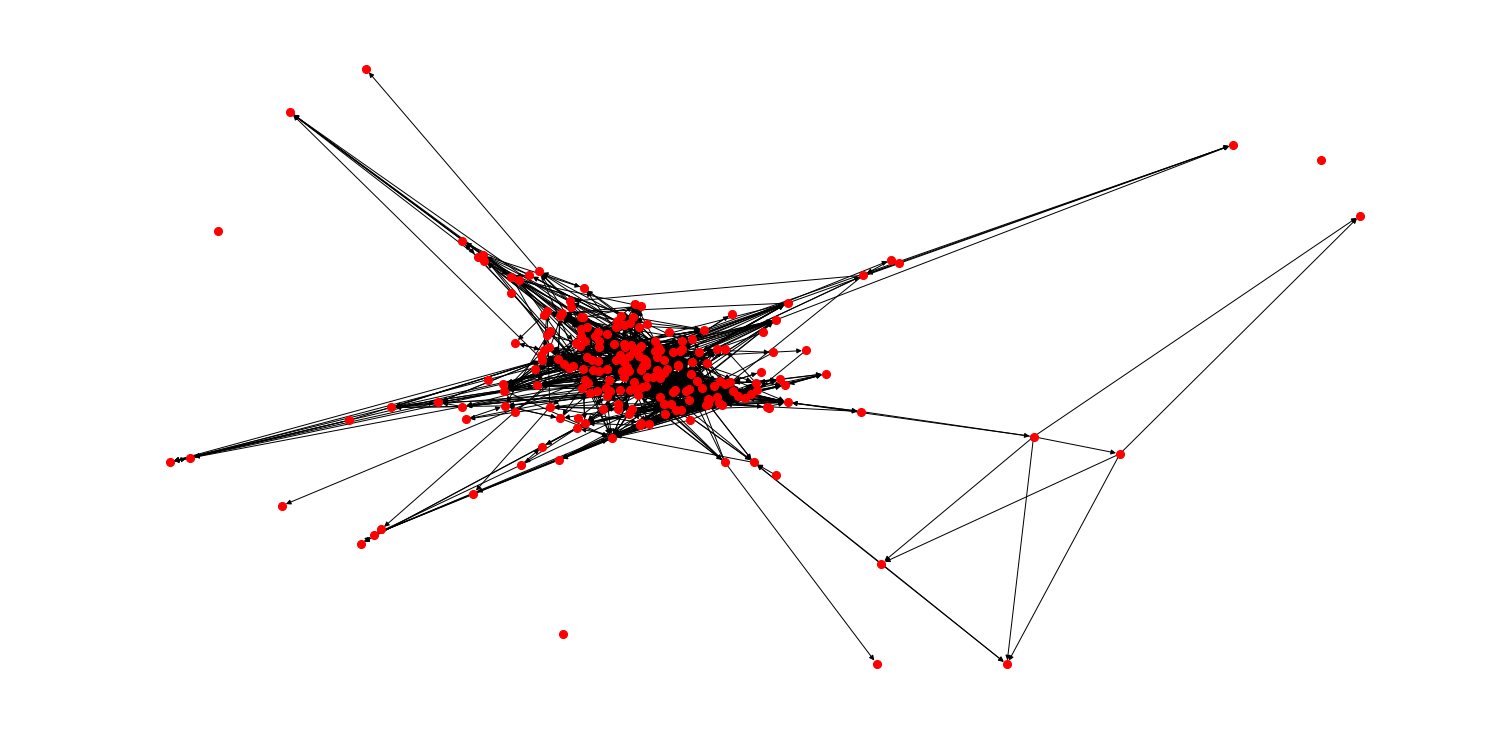

In [28]:
plt.figure(figsize=(20,10))
nx.draw_spring(DG,node_size=65)
plt.show()

We see that we have three movies that are isolated, which means that they are not connected to the rest of the network. We can see the three nodes with the function nx.isolates(DG).

In [62]:
list(nx.isolates(DG))

["Recess School's Out",
 'Spies in Disguise',
 'Victory Through Air Power (film)']

* Recess: School's Out: Is a Disney TV-show that made a movie. This could be a reason why the movie does not connect with any other movies in the network. The other Disney movies in the network is only movies or was made a TV-show after the movie. 
* Spies in Disguise: Is a new movie from 2019 (december) and is primearly a Blue Sky production. The reason it probably does not connect to any other is that the other Blue Sky productions is not as new as Spies in Disguise.
* Victory Through Air Power (film): This is an unusual film by Disney. It is a animated documentary based on the book *Victory Through Air Power* by Alexander P. de Seversky from 1942 which is not the movies Disney normally produced. They usually produce movies from fairy tales to kids and not produce documentary from World War 2. 

We will remove the isolated nodes from the network.

In [116]:
print("Number of nodes before removing isolates: " +str(DG.number_of_nodes()))
DG.remove_nodes_from(list(nx.isolates(DG))) #removing the nodes without links 
print("Number of nodes after removing isolates: " +str(DG.number_of_nodes()))
print("Number of edges: " +str(DG.number_of_edges()))

Number of nodes before removing isolates: 221
Number of nodes after removing isolates: 218
Number of edges: 1350


Our network now contains 218 nodes and 1350 edges. 

## 2.2 Degree distributions

We will start by exploring the degree distribution of the in and out degree in our network.

In [117]:
#Extracting the in degree distribution
in_degree_sequence = sorted([d for n, d in DG.in_degree()], reverse=True)
in_degreeCount = collections.Counter(in_degree_sequence)
in_deg, in_cnt = zip(*in_degreeCount.items())

#Extracting the out degree distribution
out_degree_sequence = sorted([d for n, d in DG.out_degree()], reverse=True)
out_degreeCount = collections.Counter(out_degree_sequence)
out_deg, out_cnt = zip(*out_degreeCount.items())

#Making hist and bins for the degree distribution
degree_in = [val for (node, val) in sorted(DG.in_degree(), key=lambda pair: pair[0])] 
degree_out = [val for (node, val) in sorted(DG.out_degree(), key=lambda pair: pair[0])]  

v1 = np.arange(start = min(degree_in), stop = max(degree_in)+1, step = 1)
hist1, bins1 = np.histogram(degree_in, bins = v1)

v2 = np.arange(start = min(degree_out), stop = max(degree_out)+1, step = 1)
hist2, bins2 = np.histogram(degree_out, bins = v2)

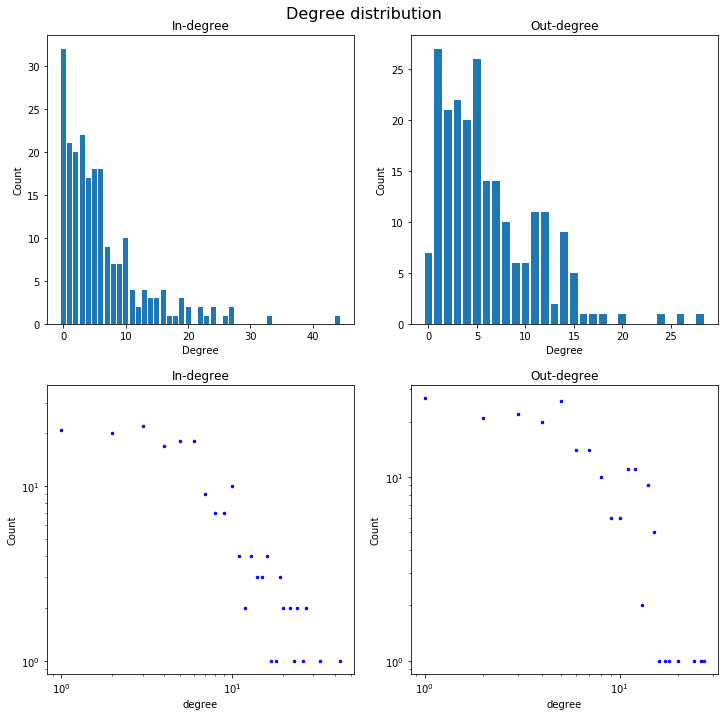

In [248]:
#Plotting the degree distribution

fig, axs = plt.subplots(2, 2, figsize=(10,10),constrained_layout=True)
axs[0,0].bar(in_deg, in_cnt)
axs[0,0].set_title("In-degree")
axs[0,0].set_ylabel("Count")
axs[0,0].set_xlabel("Degree")

fig.suptitle('Degree distribution', fontsize=16)

axs[0,1].bar(out_deg, out_cnt)
axs[0,1].set_title("Out-degree")
axs[0,1].set_ylabel("Count")
axs[0,1].set_xlabel("Degree")

axs[1,0].loglog(bins1[:-1],hist1,'o',color='blue', markersize=2.5)
axs[1,0].set_title('In-degree')
axs[1,0].set_xlabel("degree")
axs[1,0].set_ylabel("Count")
fig.suptitle('Degree distribution', fontsize=16)

axs[1,1].loglog(bins2[:-1],hist2,'o', color='blue', markersize=2.5)
axs[1,1].set_xlabel("degree")
axs[1,1].set_title('Out-degree')
axs[1,1].set_ylabel("Count")


plt.show()

Both in and out degree seems to follow a power law since many nodes have a low degree and a few nodes has a high degree. Accordingly, the network is scale-free.

From the plots above we gained a generel look over det degree distributions, so now let us have a look at specific statistics for in and out degree.

In [15]:
#Creating vector for in and out degree
out=[]
for i in range (len(DG.out_degree())):
    out.append(list(DG.out_degree())[i][1])

ind=[]
for i in range (len(DG.in_degree())):
    ind.append(list(DG.in_degree())[i][1])

In [16]:
#Basic statistics for the network
print("Mean of outdegree "+str(np.mean(out)))
print("Mean of indegree "+str(np.mean(ind)))
print("\n")
print("Median of outdegree "+str(np.median(out)))
print("Median of indegree "+str(np.median(ind)))
print("\n")
print("Mode of outdegree "+str(statistics.mode(out)))
print("Mode of indegree "+str(statistics.mode(ind)))
print("\n")
print("Minimum of outdegree "+str(min(out)))
print("Minimum of indegree "+str(min(ind)))
print("\n")
print("Maximum of outdegree "+str(max(out)))
print("Maximum of indegree "+str(max(ind)))

Mean of outdegree 6.192660550458716
Mean of indegree 6.192660550458716


Median of outdegree 5.0
Median of indegree 4.0


Mode of outdegree 1
Mode of indegree 0


Minimum of outdegree 0
Minimum of indegree 0


Maximum of outdegree 28
Maximum of indegree 44


We observe that the basic statistics for in and out degree are close to each other. They only differentiate from each other when we are looking at the maximum value. Here we have a node with 44 in indegree and 28 in outdegree.

Lets us take a look at each production studio network in the network and compare the values to the total network.

In [ ]:
#Lists of in and outdegree for each production studio
Disney_Network_out = []
Disney_Network_in = []
Pixar_Network_out = []
Pixar_Network_in = []
WB_Network_out = []
WB_Network_in = []
Illu_Network_out = []
Illu_Network_in = []
DW_Network_out = []
DW_Network_in = []
BS_Network_out = []
BS_Network_in = []
Sony_Network_out = []
Sony_Network_in = []
Sul_Network_out = []
Sul_Network_in = []

In [11]:
for node in list(DG.nodes):
    if DG.nodes[node]['universe'] == 'Disney': 
        Disney_Network_out.append(DG.out_degree(node))
        Disney_Network_in.append(DG.in_degree(node))
    elif DG.nodes[node]['universe'] == 'Pixar': 
        Pixar_Network_out.append(DG.out_degree(node))
        Pixar_Network_in.append(DG.in_degree(node))
    elif DG.nodes[node]['universe'] == 'Warner Bros. Animation productions': 
        WB_Network_out.append(DG.out_degree(node))
        WB_Network_in.append(DG.in_degree(node))
    elif DG.nodes[node]['universe'] == 'Illumination': 
        Illu_Network_out.append(DG.out_degree(node))
        Illu_Network_in.append(DG.in_degree(node))
    elif DG.nodes[node]['universe'] == 'DreamWorks': 
        DW_Network_out.append(DG.out_degree(node))
        DW_Network_in.append(DG.in_degree(node))
    elif DG.nodes[node]['universe'] == 'Blue Sky': 
        BS_Network_out.append(DG.out_degree(node))
        BS_Network_in.append(DG.in_degree(node))
    elif DG.nodes[node]['universe'] == 'Sony Pictures Animation productions': 
        Sony_Network_out.append(DG.out_degree(node))
        Sony_Network_in.append(DG.in_degree(node))
    elif DG.nodes[node]['universe'] == 'Sullivan Bluth Studios': 
        Sul_Network_out.append(DG.out_degree(node))
        Sul_Network_in.append(DG.in_degree(node))

In [12]:
total = [Disney_Network_out,Pixar_Network_out,WB_Network_out,Illu_Network_out,DW_Network_out,BS_Network_out,Sony_Network_out,Sul_Network_out,Disney_Network_in,Pixar_Network_in,WB_Network_in,Illu_Network_in,DW_Network_in,BS_Network_in,Sony_Network_in,Sul_Network_in]
names = ["Disney out", "Pixar out", "Warner Bros out", "Illumination out", "DreamWorks out", "Blue Sky out", "Sony out", "Sullivan out","Disney in", "Pixar in", "Warner Bros in", "Illumination in", "DreamWorks in", "Blue Sky in", "Sony in", "Sullivan in"]

In [24]:
#Mean of in and out degree
for i in range(len(total)):
    print(f"Mean of {names[i]}:"+str(np.mean(total[i])))

Mean of Disney out:7.053763440860215
Mean of Pixar out:10.73913043478261
Mean of Warner Bros out:3.0
Mean of Illumination out:5.2
Mean of DreamWorks out:5.526315789473684
Mean of Blue Sky out:3.25
Mean of Sony out:2.6315789473684212
Mean of Sullivan out:6.375
Mean of Disney in:7.462365591397849
Mean of Pixar in:12.043478260869565
Mean of Warner Bros in:2.8
Mean of Illumination in:5.0
Mean of DreamWorks in:4.947368421052632
Mean of Blue Sky in:2.5833333333333335
Mean of Sony in:1.894736842105263
Mean of Sullivan in:4.0


From the mean of in and out degree we see that Disney, Warner Bros. and Illumination has around the same mean for both in and outdegree. That means that they link equally to others as others link to them.
Pixar as the only production studio has a lower indegree than outdegree, which means they has more links to themselves than they has to others. 
DreamWorks, Blue Sky, Sony and Sullivan all have a higher outdegree than indegree, which means that these movies has more links to others.
The mean of both in and outdegree for the whole network was 6.2. Disney and Pixar are the only two production studios that are above that. So these must be the most popular movies, which is also to expect since the majority of the nodes in the network are Disney and Pixar movies.

In [25]:
#Median of in and out degree
for i in range(len(total)):
    print(f"Median of {names[i]}:"+str(np.median(total[i])))

Median of Disney out:6.0
Median of Pixar out:11.0
Median of Warner Bros out:3.0
Median of Illumination out:4.0
Median of DreamWorks out:5.0
Median of Blue Sky out:3.0
Median of Sony out:2.0
Median of Sullivan out:6.5
Median of Disney in:5.0
Median of Pixar in:11.0
Median of Warner Bros in:2.0
Median of Illumination in:4.0
Median of DreamWorks in:4.0
Median of Blue Sky in:2.5
Median of Sony in:1.0
Median of Sullivan in:3.5


There are not that big a difference between the median of in and outdegree for each production studio. What is interesting here is to notice that Pixar has almost twice as big a median of in and outdegree as the second biggest. We can say from that that Pixar movies generally must have a lot of links. In compare to the whole network Pixar is the one dragging the median up.

In [26]:
#Minimum in and out degree
for i in range(len(total)):
    print(f"Minimum of {names[i]}:"+str(min(total[i])))

Minimum of Disney out:0
Minimum of Pixar out:3
Minimum of Warner Bros out:1
Minimum of Illumination out:0
Minimum of DreamWorks out:1
Minimum of Blue Sky out:0
Minimum of Sony out:1
Minimum of Sullivan out:2
Minimum of Disney in:0
Minimum of Pixar in:0
Minimum of Warner Bros in:0
Minimum of Illumination in:2
Minimum of DreamWorks in:0
Minimum of Blue Sky in:0
Minimum of Sony in:0
Minimum of Sullivan in:2


There is nothing interessting looking at the minimum in and outdegree apart from the fact that Pixar movies has the highest outdegree.

In [27]:
#Maximum in and out degree
for i in range(len(total)):
    print(f"Maximum of {names[i]}:"+str(max(total[i])))

Maximum of Disney out:28
Maximum of Pixar out:26
Maximum of Warner Bros out:6
Maximum of Illumination out:14
Maximum of DreamWorks out:18
Maximum of Blue Sky out:7
Maximum of Sony out:5
Maximum of Sullivan out:11
Maximum of Disney in:44
Maximum of Pixar in:27
Maximum of Warner Bros in:12
Maximum of Illumination in:11
Maximum of DreamWorks in:23
Maximum of Blue Sky in:7
Maximum of Sony in:6
Maximum of Sullivan in:6


From the maximum in and outdegree we can see that Disney and Pixar are the most popular movies to be connected to. From the maximum value for the big network we can see that it is Disneys movies. 

## 2.3 Exploratory analysis with visualizations

In this section we will try to visualize data in different ways, but first let us have a look at the five most connected movies by total degree, indegree and outdegree.

In [28]:
d = sorted(DG.degree, key=lambda x: x[1], reverse=True)
d_in = sorted(DG.in_degree, key=lambda x: x[1], reverse=True)
d_out = sorted(DG.out_degree, key=lambda x: x[1], reverse=True)
print("5 most connected movies (total degree):")
print(d[0:5])
print(" ")
print("5 most connected to movies (in-degree):")
print(d_in[0:5])
print(" ")
print("5 most connected from movies (out-degree):")
print(d_out[0:5])

5 most connected movies (total degree):
[('The Lion King', 58), ('Frozen (2013 film)', 51), ('Toy Story 3', 50), ('Toy Story', 42), ('Shrek', 41)]
 
5 most connected to movies (in-degree):
[('The Lion King', 44), ('Snow White and the Seven Dwarfs (1937 film)', 33), ('Frozen (2013 film)', 27), ('Toy Story', 27), ('Beauty and the Beast (1991 film)', 26)]
 
5 most connected from movies (out-degree):
[('The Princess and the Frog', 28), ('Toy Story 3', 26), ('Frozen (2013 film)', 24), ('Tangled', 20), ('Shrek', 18)]


We see that 'The Lion King' is the most connected movie in total degree sharply followed by 'Frozen' and 'Toy Story 3'. We know they are all popular movies, so let us have a look at the budget and gross for the five most connected movies. We expect that the five movies earned a lot of money.

### 2.3.1 Budget and gross

From above we figured out that 'The Lion King', 'Frozen', 'Toy Story 3', 'Toy Story' and 'Shrek' were the five most connected movies by total degree, that means that these five movies are the ones that are mentioned the most in other movies wikipedia pages and at the same time they mention a lot of other movies in theirs wikipedia page. We expect that those five movies earned a lot. So for fun let us have a look at the budget and the gross for those five movies.

Text(0, 0.5, 'Million dollars')

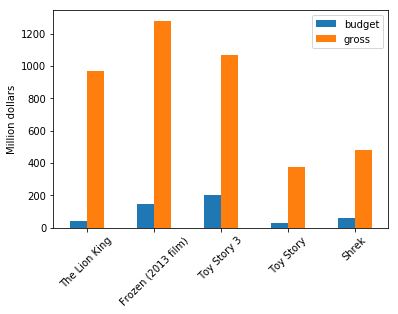

In [69]:
budget = [Data['Budget'][list(Data['Movie']).index('The Lion King')], Data['Budget'][list(Data['Movie']).index('Frozen (2013 film)')], Data['Budget'][list(Data['Movie']).index('Toy Story 3')], Data['Budget'][list(Data['Movie']).index('Toy Story')], Data['Budget'][list(Data['Movie']).index('Shrek')]]
gross = [Data['Gross'][list(Data['Movie']).index('The Lion King')], Data['Gross'][list(Data['Movie']).index('Frozen (2013 film)')], Data['Gross'][list(Data['Movie']).index('Toy Story 3')], Data['Gross'][list(Data['Movie']).index('Toy Story')], Data['Gross'][list(Data['Movie']).index('Shrek')]]
index = ['The Lion King', 'Frozen (2013 film)', 'Toy Story 3',
         'Toy Story', 'Shrek']
df = pd.DataFrame({'budget': budget,
                   'gross': gross}, index=index)
ax = df.plot.bar(rot=45)
ax.set_ylabel("Million dollars")

As expected all of the five movies earned more than triple of their budget. 

### 2.3.2 Development over the years

Next let us have a look at how the number of movies produced developed over the years.

In [118]:
#We make a list of all distinct years a movie was produced
year=list(set(list(Data['Year'])))

In [119]:
#We count how many movies were produced in each year
yearcount=[]
for y in year:
    yearcount.append(list(Data['Year']).count(y))

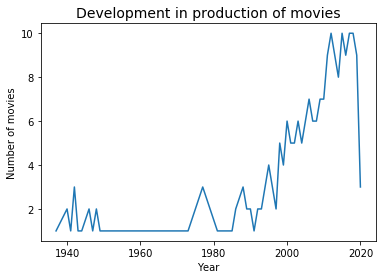

In [121]:
plt.plot(year, yearcount)
plt.title('Development in production of movies',size=14)
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.show()

We see a development that has only been going upwards (except the year 2020 which we suspect is due to Corona pandemic). In the late 1930's and start 1940's Disney began producing movies.  

### 2.3.3 Profit 

In the dataset we have added a column called "Profit (percent)", where we have calculated the profit. We would like to make a histrogram of the profit, so we can see how the movies are distributed in the bins.

In [122]:
#We make a list of the profit column in our dataset. We remove if NaN value. 
profit=Data['Profit (percent)'].dropna().tolist()

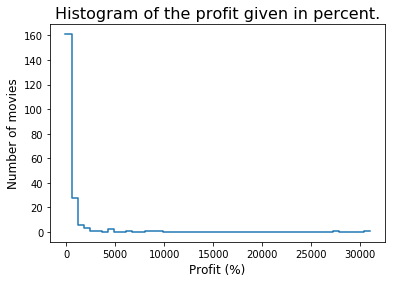

In [125]:
hist, bins = np.histogram(profit, bins = 50)

plt.figure(figsize=(6,4))
plt.plot(bins, np.insert(hist, 0, hist[0]), drawstyle='steps')
plt.title("Histogram of the profit given in percent.", size=16)
plt.xlabel("Profit (%)",size=12)
plt.ylabel("Number of movies",size=12)
plt.show()

It is very difficult to see how the movies distribute in the bins, since we have two movies that respectively earned around 28000% and 31000%. For fun we want to figure out which movies earned that much.

In [35]:
#sorting the list with profits
sp=np.sort(profit)

In [36]:
Data.loc[Data['Profit (percent)'] == sp[-2]]

Movie Production  Year  Budget  \
102  Snow White and the Seven Dwarfs (1937 film)     Disney  1937     1.5   

     Gross  Profit (percent)                         RottenTomatoName  
102  418.0      27766.666667  1048445-snow_white_and_the_seven_dwarfs

In [37]:
Data.loc[Data['Profit (percent)'] == sp[-1]]

Movie Production  Year  Budget  Gross  Profit (percent) RottenTomatoName
106  Bambi     Disney  1942    0.86  267.4      30993.023256            bambi

We see that the two movies that earned the biggest profit were two disney original movies respectively 'Snow White and the Seven Dwarfs' and 'Bambi'. Both movies are made around 1940, which is quite interesting, that they made that much. We have investigated and now know that old movies would be reissued in the cinema every ten years, since VHS and DVD did not exist at that time. <br> 
We try making a histogram of the profit again but this time without Snow White and Bambi. 

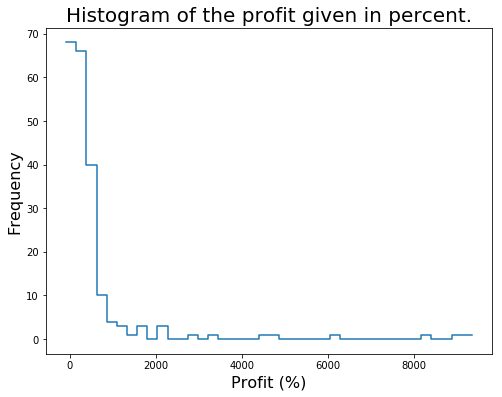

In [38]:
hist, bins = np.histogram(sp[:-2], bins = 40)

plt.figure(figsize=(8,6))
plt.plot(bins, np.insert(hist, 0, hist[0]), drawstyle='steps')
plt.title("Histogram of the profit given in percent.", size=20)
plt.xlabel("Profit (%)",size=16)
plt.ylabel("Frequency",size=16)
plt.show()

It is still quite difficult to see anything from the plot, but we can conclude that most movies made around 0-200% in profit.

### 2.3.4 Budget, gross, profit

We look at the budget, gross and profit over the years.

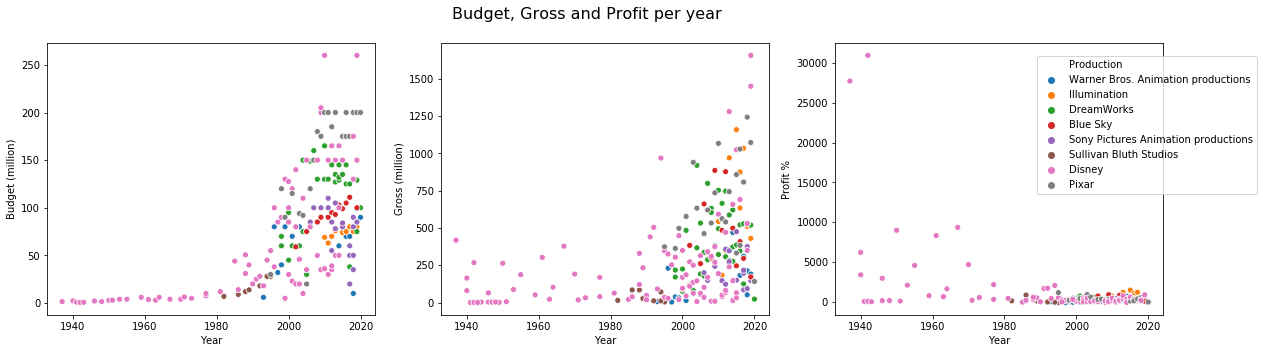

In [109]:
fig, axes= plt.subplots(nrows=1, ncols=3, squeeze=False,figsize=(20,5))
p1=sns.scatterplot(x="Year", y="Budget", data=Data, hue="Production",ax=axes[0][0],legend=False);
p1.set(ylabel='Budget (million)')
p2=sns.scatterplot(x="Year", y="Gross", data=Data, hue="Production",ax=axes[0][1],legend=False)
plt.suptitle("Budget, Gross and Profit per year",size=16)
p2.set(ylabel='Gross (million)')
p3=sns.scatterplot(x="Year", y="Profit (percent)", data=Data, hue="Production",ax=axes[0][2],);
p3.set(ylabel='Profit %')
p3.legend(loc='right', bbox_to_anchor=(1.3, 0.7), ncol=1)
plt.show()

As expected there is an increase in bugdet and gross for movies over the years. However the profit in percent is decreasing this could be due to the increase in bugdet and gross. Furthermore, the movies from 1940's has been reissue many times in the cinemas because at that time people did not have VHS and DVD so they could not buy the movies. This is propably why the profit in percent is high for movies made in 1940's.

### 2.3.5 Distribution of average user score
Let us move on to some visualizations with the movie reviews. First we remove colon from the dictionary, so the moviename corresponds to the movienames in the dataset and network. 

In [76]:
ReviewDict = {x.replace(':', ''): v  
     for x, v in ReviewDict.items()} 

The average user score of the movies is added to the dictionary that contains the movie reviews.

In [70]:
for name in Data.Movie.values:
    a=np.mean(ReviewDict[name][1])
    ReviewDict[name]=[ReviewDict[name][0],ReviewDict[name][1],a]

The user score can be from zero to five and the distribution for the average score is plotted below.

In [74]:
AverageScore=[]
for name in Data.Movie.values:
    AverageScore.append(ReviewDict[name][2])

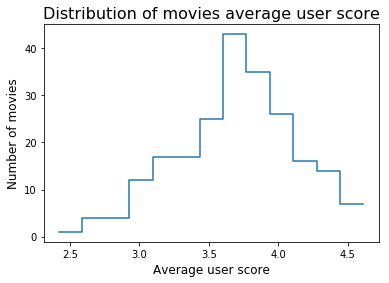

In [126]:
hist, bins = np.histogram(AverageScore, bins = 'auto')

plt.figure(figsize=(6,4))
plt.plot(bins, np.insert(hist, 0, hist[0]), drawstyle='steps')
plt.title("Distribution of movies average user score", size=16)
plt.xlabel("Average user score",size=12)
plt.ylabel("Number of movies",size=12)
plt.show()

The distribution of the average user score follows a normal distribution where most movies have a user score about 3.6 to 3.7. 

### 2.3.6 Distribution of reviews

We look at the distribution of number at reviews on the movies.

In [127]:
AverageReviews=[]
for name in Data.Movie.values:
    AverageReviews.append(len(ReviewDict[name][0]))

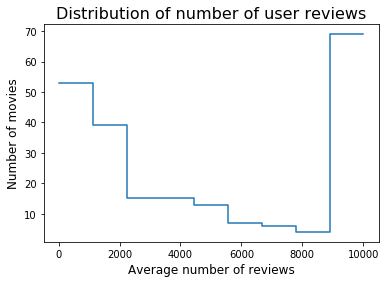

In [128]:
hist5, bins5 = np.histogram(AverageReviews, bins = 'auto')

plt.figure(figsize=(6,4))
plt.plot(bins5, np.insert(hist5, 0, hist5[0]), drawstyle='steps')
plt.title("Distribution of number of user reviews", size=16)
plt.xlabel("Average number of reviews",size=12)
plt.ylabel("Number of movies",size=12)
plt.show()

The upper bound for number of loaded movie reviews is clearly seen in this plot. There is about 70 movies where there is more than 10,000 user reviews. Moverover there is a decreasing tendency until 10,000 reviews. This means that there is many movies with low number of reviews and many movies with high number of reviews.

### 2.3.7 Average user score, number of reviews vs. budget, gross

The average user score and number of reviews is plotted agianst gross and budget to see if we can detect any trends.

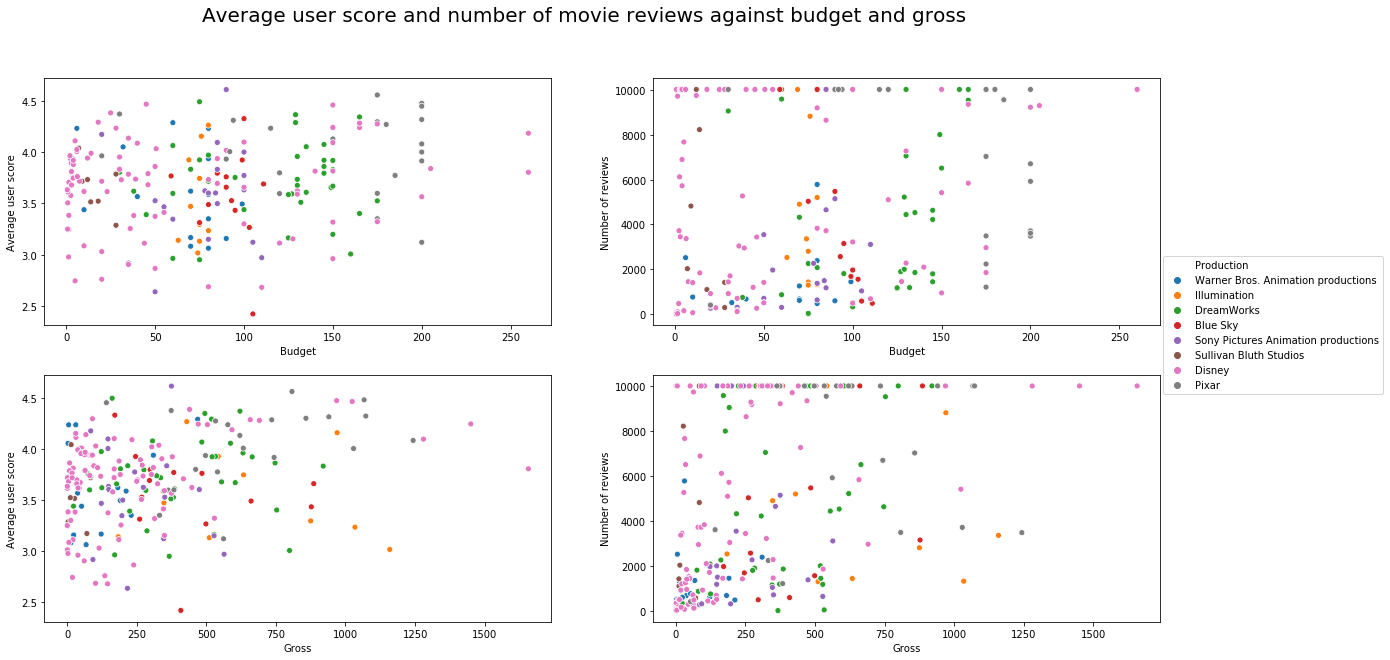

In [131]:
fig, axes= plt.subplots(nrows=2, ncols=2, squeeze=False,figsize=(20,10))
p1=sns.scatterplot(x="Budget", y=AverageScore, data=Data, hue="Production",ax=axes[0][0],legend=False);
p1.set(ylabel='Average user score')
p2=sns.scatterplot(x="Budget", y=AverageReviews, data=Data, hue="Production",ax=axes[0][1])
p2.set(ylabel='Number of reviews')
p3=sns.scatterplot(x="Gross", y=AverageScore, data=Data, hue="Production",ax=axes[1][0],legend=False);
p3.set(ylabel='Average user score')
p4=sns.scatterplot(x="Gross", y=AverageReviews, data=Data, hue="Production",ax=axes[1][1],legend=False)
p4.set(ylabel='Number of reviews')

plt.suptitle("Average user score and number of movie reviews against budget and gross",size=20)
p2.legend(loc='right', bbox_to_anchor=(1.45, 0.001), ncol=1)
plt.show()

One thing that can be seen in the scatter plots is that the production studio Illumination always has the same budget for their movies but even though they have the same budget there is a clear difference in how well the movies are making. Otherwise there is no clear pattern between number of reviews and average user score contra gross and budget. Maybe there is a pattern between average user score, number of reviews and year.

### 2.3.8 Average user score, number of reviews vs. year

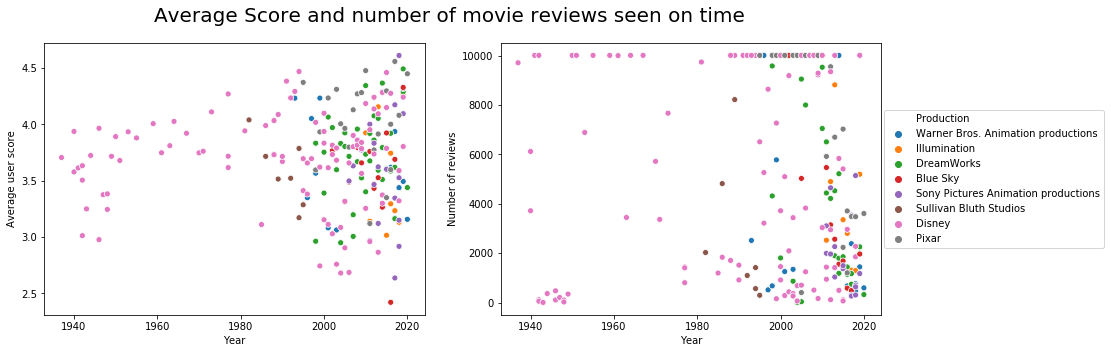

In [132]:
fig, axes= plt.subplots(nrows=1, ncols=2, squeeze=False,figsize=(15,5))
p1=sns.scatterplot(x="Year", y=AverageScore, data=Data, hue="Production",ax=axes[0][0],legend=False);
p1.set(ylabel='Average user score')
p2=sns.scatterplot(x="Year", y=AverageReviews, data=Data, hue="Production",ax=axes[0][1])
plt.suptitle("Average Score and number of movie reviews seen on time",size=20)
p2.legend(loc='right', bbox_to_anchor=(1.6, 0.5), ncol=1)
p2.set(ylabel='Number of reviews')
plt.show()

As expected Disney is the only production studio until 1980. The movies that where produced between 1937 to 1980 from Disney scores roughly between three and four, which is above medium since the score is between zero and five. Otherwise the average score of the movies are spread out in an interval between 2.5 to 4.5.

### 2.3.9 Average user score in each production studios

We make a dictionary containing the productions studios as keys and the average score of each production studio as values.

In [20]:
ProductionDict={}
for production in Data.Production.unique():
    score=[]
    for movie in Data.loc[Data['Production'] == production]['Movie']:
        score.append(ReviewDict[movie][2])
    ProductionDict[production]=[mean(score),len(score)]

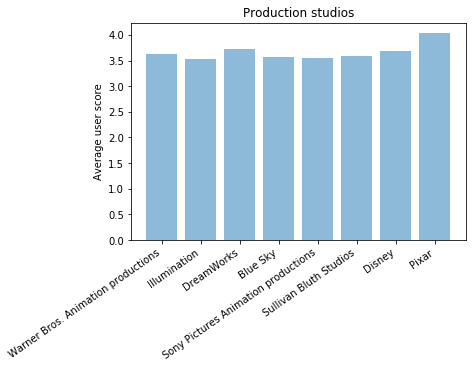

In [21]:
objects = ProductionDict.keys()
y_pos = np.arange(len(objects))
performance = [value[0] for value in ProductionDict.values()]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects,rotation=35,ha='right')
plt.ylabel('Average user score')
plt.title('Production studios')

plt.show()

It is clearly seen that Pixar has the best average user score, but overall the user score for the production studios is almost the same. All of them has good movies and bad movies, but what are the best movies and the worst movies? This we will find below.

### 2.3.10 Average user scores 

In [22]:
sort_avgscore = sorted(ReviewDict.items(), key=lambda x: x[1][2], reverse=True)

In [23]:
print("Best 10 movies by user score\n")
print(tabulate([(sort_avgscore[i][0],ReviewDict[sort_avgscore[i][0]][2],len(ReviewDict[sort_avgscore[i][0]][0]),Data['Production'][list(Data['Movie']).index(sort_avgscore[i][0])]) for i in range (0, 10)], headers=["Movie", "Average user score", "Number of reviews","Production studio"]))

Best 10 movies by user score

Movie                                Average user score    Number of reviews  Production studio
---------------------------------  --------------------  -------------------  -----------------------------------
Spider-Man: Into the Spider-Verse               4.61186                 5145  Sony Pictures Animation productions
Coco (2017 film)                                4.55892                 3488  Pixar
Abominable (2019 film)                          4.49292                 2260  DreamWorks
Toy Story 3                                     4.47747                10009  Pixar
The Lion King                                   4.46963                10009  Disney
Zootopia                                        4.46103                 5414  Disney
Onward (film)                                   4.44958                 3610  Pixar
Beauty and the Beast (1991 film)                4.3843                 10009  Disney
Toy Story                                       4.

In [24]:
print("Worst 10 movies by user score\n")
print(tabulate([(sort_avgscore[-i][0],ReviewDict[sort_avgscore[-i][0]][2],len(ReviewDict[sort_avgscore[-i][0]][0]),Data['Production'][list(Data['Movie']).index(sort_avgscore[-i][0])]) for i in range (1, 11)], headers=["Movie", "Average user score", "Number of reviews","Production studio"]))

Worst 10 movies by user score

Movie                              Average user score    Number of reviews  Production studio
-------------------------------  --------------------  -------------------  -----------------------------------
Ice Age: Collision Course                     2.42092                  588  Blue Sky
The Emoji Movie                               2.63699                 3544  Sony Pictures Animation productions
Home on the Range (2004 film)                 2.6807                   689  Disney
The Wild                                      2.68616                 3830  Disney
Doug's 1st Movie                              2.74375                  160  Disney
The Jungle Book 2                             2.75946                  370  Disney
Planes (film)                                 2.86514                 1420  Disney
Valiant (film)                                2.90423                  710  Disney
Goosebumps 2: Haunted Halloween               2.91774               

### 2.3.11 User score on reviews

We will visualize the user score distributed on reviews. It is possible to give 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5 and 5.

In [94]:
score=[]
for name in Data.Movie.values:
    score=score+(ReviewDict[name][1])

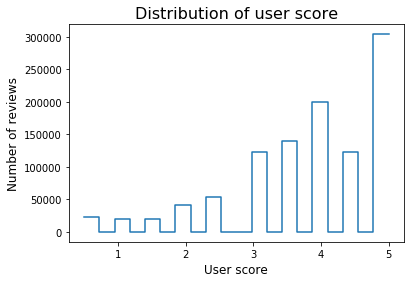

In [100]:
hist, bins = np.histogram(score, bins = 20)

plt.figure(figsize=(6,4))
plt.plot(bins, np.insert(hist, 0, hist[0]), drawstyle='steps')
plt.title("Distribution of user score", size=16)
plt.xlabel("User score",size=12)
plt.ylabel("Number of reviews",size=12)
plt.show()

General we see that the reviewer are giving good scores to the movies. Only a few reviews has a score lower than 3.

## 2.4 Visualizations of the network

In this section we will use the ForceAtlas2 algorithm to visualize the network. The ForceAtlas2 algorithm is a continous algorithm and a force directed layout. We will make multiple plots, where we have scaled the nodesize according to the degree, budget and gross.

First we will make our colormap depending on the production studio.

In [35]:
#Making the color map
color_list = []
for n, d in DG.nodes(data=True):
    if d['universe'] == 'Disney':
        color_list.append("#ff0000") #red
    elif d['universe'] == 'Pixar':
        color_list.append("#00ffff") #light blue
    elif d['universe'] == 'Warner Bros. Animation productions':
        color_list.append("#f8ff6b") #yellow
    elif d['universe'] == 'Illumination':
        color_list.append("#ffc0cb") #light pink
    elif d['universe'] == 'DreamWorks':
        color_list.append("#735686") #purple
    elif d['universe'] == 'Blue Sky':
        color_list.append("#215a30") #green
    elif d['universe'] == 'Sony Pictures Animation productions':
        color_list.append("#97dc91") #light green
    elif d['universe'] == 'Sullivan Bluth Studios':
        color_list.append("#11457f") #orange

To be able to use the ForceAtlas2 algorithm we need to make our network undirected, we will call it UG.

In [133]:
# generate undirected network
UG = DG.to_undirected()

### 2.4.1 Nodesize according to degree

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 173.24it/s]


BarnesHut Approximation  took  1.36  seconds
Repulsion forces  took  9.79  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.06  seconds
AdjustSpeedAndApplyForces step  took  0.17  seconds


C:\Users\jodth\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


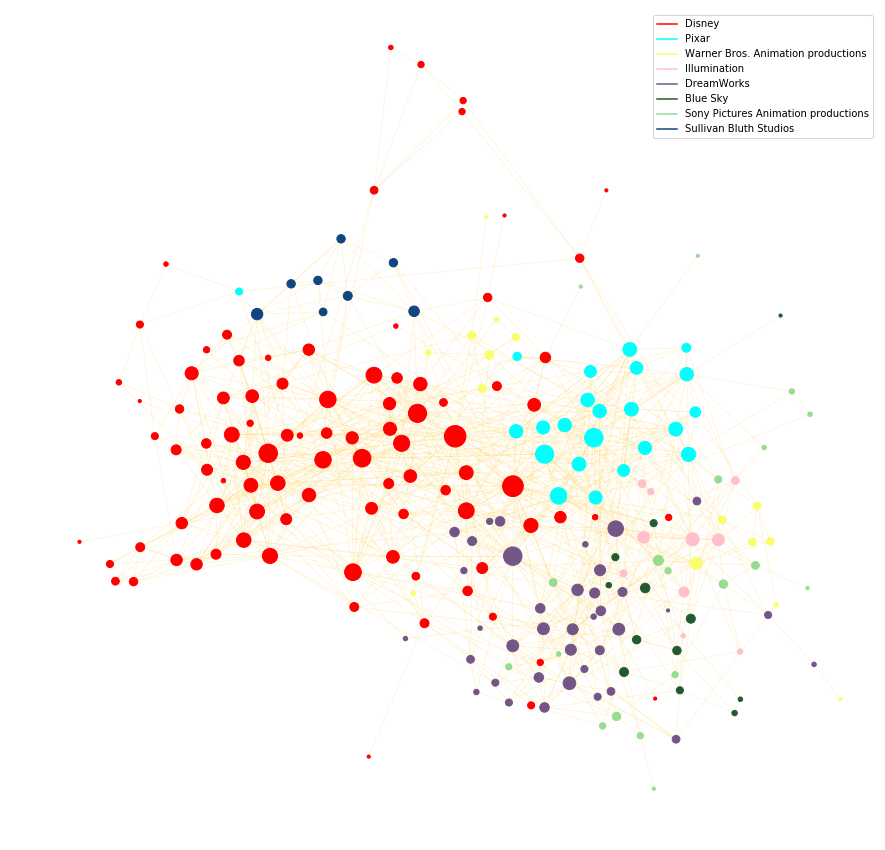

In [36]:
# Nodesize according to degree
node_degree = dict(UG.degree())
node_size = [v * 10 for v in node_degree.values()]

forceatlas2 = ForceAtlas2(
                        #--> Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1,

                        #--> Performance
                        jitterTolerance=0.2,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.6,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        #--> Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        #--> Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(UG, pos=None, iterations=2000)

plt.figure(figsize=(15,15))
color_legend = {'Disney': "#ff0000" , 'Pixar': "#00ffff", 'Warner Bros. Animation productions':"#f8ff6b", 'Illumination': "#ffc0cb", 'DreamWorks':"#735686", 'Blue Sky':"#215a30", 'Sony Pictures Animation productions':"#97dc91",'Sullivan Bluth Studios':"#11457f"}
for label in color_legend:
    plt.plot([0],[0],color=color_legend[label],label=label)
plt.legend()
nx.draw_networkx_nodes(UG, positions, node_size=node_size, node_color=color_list)
nx.draw_networkx_edges(UG, positions, edge_color="#FFC733",alpha = 0.3,width= 0.5)
plt.axis('off')
plt.show()

We clearly see a Disney, Pixar, DreamWorks and Sullivan cluster in the network. It is clear that Disney, Pixar and DreamWorks movies are the ones with the largest degree. 

### 2.4.2 Nodesize according to budget

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 169.47it/s]


BarnesHut Approximation  took  0.87  seconds
Repulsion forces  took  10.38  seconds
Gravitational forces  took  0.07  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.20  seconds


C:\Users\jodth\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


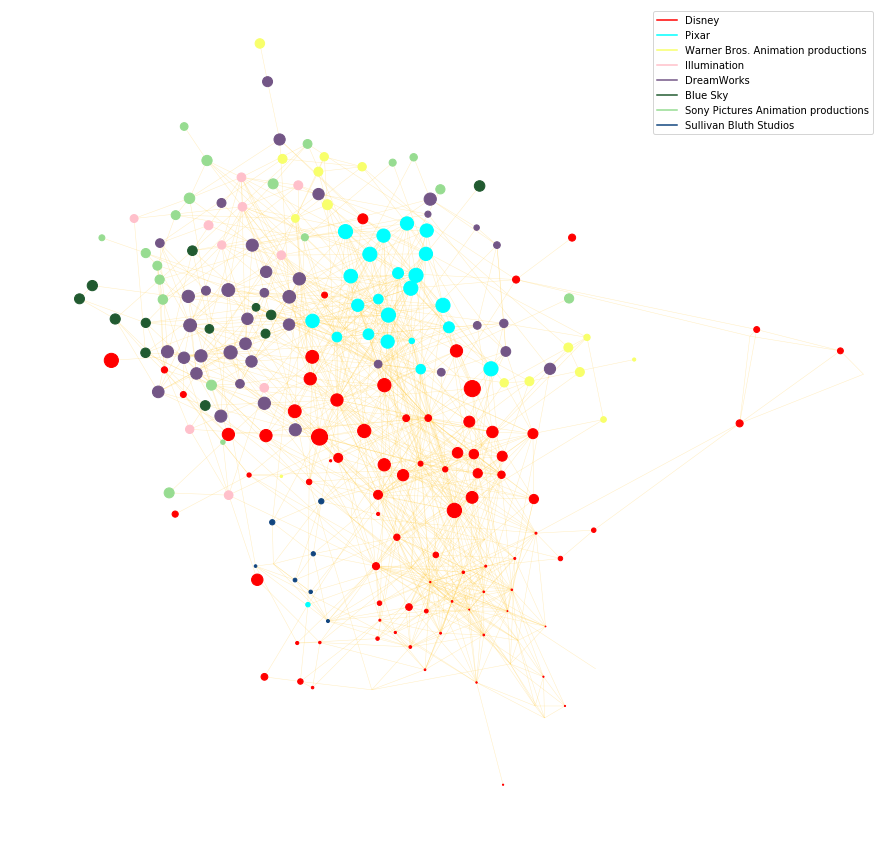

In [37]:

# Nodesize according to budget
node_budget= nx.get_node_attributes(UG, 'budget')
node_size = [v for v in node_budget.values()]


forceatlas2 = ForceAtlas2(
                        #--> Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1,

                        #--> Performance
                        jitterTolerance=0.2,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.6,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        #--> Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        #--> Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(UG, pos=None, iterations=2000)

plt.figure(figsize=(15,15))
color_legend = {'Disney': "#ff0000" , 'Pixar': "#00ffff", 'Warner Bros. Animation productions':"#f8ff6b", 'Illumination': "#ffc0cb", 'DreamWorks':"#735686", 'Blue Sky':"#215a30", 'Sony Pictures Animation productions':"#97dc91",'Sullivan Bluth Studios':"#11457f"}
for label in color_legend:
    plt.plot([0],[0],color=color_legend[label],label=label)
plt.legend()
nx.draw_networkx_nodes(UG, positions, node_size=node_size, node_color=color_list)
nx.draw_networkx_edges(UG, positions, edge_color="#FFC733",alpha = 0.3,width= 0.5)
plt.axis('off')
plt.show()

Again we clearly see that Disney, Pixar and DreamWorks are the movies with the highest budget. Disney only have a few movies where the budget are quite larger than the other movies from Pixar and DreamWorks.

In [38]:
#Ten movies with the biggest budget
Data.sort_values(by=['Budget'],ascending=False).iloc[0:10]

Movie Production  Year  Budget   Gross  \
204      The Lion King (2019 film)     Disney  2019   260.0  1657.0   
177                        Tangled     Disney  2010   260.0   592.4   
175      The Princess and the Frog     Disney  2009   205.0   270.0   
197                   Finding Dory      Pixar  2016   200.0  1029.0   
186            Monsters University      Pixar  2013   200.0   743.6   
176                    Toy Story 3      Pixar  2010   200.0  1067.0   
180                         Cars 2      Pixar  2011   200.0   562.1   
174  A Christmas Carol (2009 film)     Disney  2009   200.0   375.0   
201                  Incredibles 2      Pixar  2018   200.0  1243.0   
203                    Toy Story 4      Pixar  2019   200.0  1073.0   

     Profit (percent)               RottenTomatoName  
204        537.307692             the_lion_king_2019  
177        127.846154                        tangled  
175         31.707317  1196003-princess_and_the_frog  
197        414.500000                   finding_dory  
186        271.800000            monsters_university  
176        433.500000                    toy_story_3  
180        181.050000                         cars_2  
174         87.500000       10008502-christmas_carol  
201        521.500000                  incredibles_2  
203        436.500000                    toy_story_4

We see that 'The Lion King' and 'Tangled' were the movies with the biggest budget.

### 2.4.3 Nodesize according to gross

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 107.76it/s]


BarnesHut Approximation  took  2.16  seconds
Repulsion forces  took  15.25  seconds
Gravitational forces  took  0.10  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.38  seconds


C:\Users\jodth\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


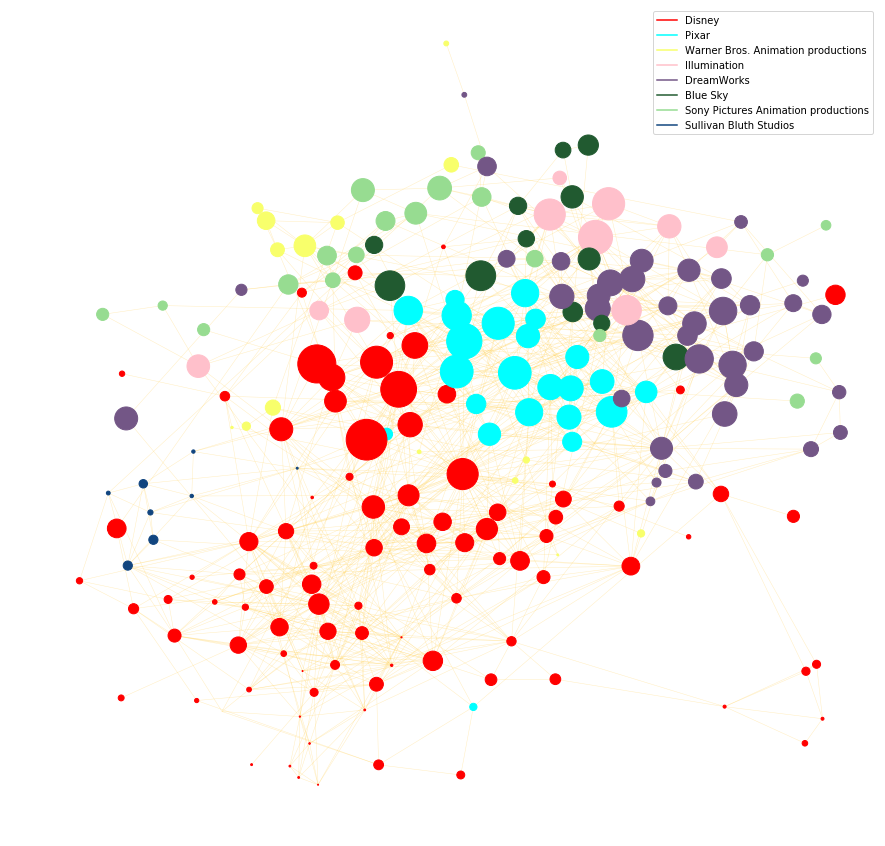

In [39]:
# Nodesize according to gross
node_gross= nx.get_node_attributes(UG, 'gross')
node_size = [v for v in node_gross.values()]

# Assign legends for each universe


forceatlas2 = ForceAtlas2(
                        #--> Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1,

                        #--> Performance
                        jitterTolerance=0.2,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.6,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        #--> Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        #--> Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(UG, pos=None, iterations=2000)

plt.figure(figsize=(15,15))
color_legend = {'Disney': "#ff0000" , 'Pixar': "#00ffff", 'Warner Bros. Animation productions':"#f8ff6b", 'Illumination': "#ffc0cb", 'DreamWorks':"#735686", 'Blue Sky':"#215a30", 'Sony Pictures Animation productions':"#97dc91",'Sullivan Bluth Studios':"#11457f"}
for label in color_legend:
    plt.plot([0],[0],color=color_legend[label],label=label)
plt.legend()
nx.draw_networkx_nodes(UG, positions, node_size=node_size, node_color=color_list)
nx.draw_networkx_edges(UG, positions, edge_color="#FFC733",alpha = 0.3,width= 0.5)
plt.axis('off')
plt.show()

In this visualization the nodes are sized according to their gross. Some of them are overlapping, but we have choose not to scale them, so we could compare it directly to the vizualization above where the nodes are sized according to their budget. 
We see that both Disney, Pixar, DreamWorks, Illumination, Blue Sky and Sony movies have a big gross (much bigger than their budget). 

## 2.5 Centrality

Now we have looked at some different stats about the network and seen it visualized in different ways. We will next calculate the centrality in the network, that identify the most important nodes within a graph. We will calculate degree centrality, betweeness centrality and eigenvector centrality.

In [40]:
#Calculating degree centrality
dc=nx.degree_centrality(DG)
sort_dc={k: v for k, v in sorted(dc.items(), key=lambda item: item[1], reverse=True)}
list(sort_dc.items())[:5]

[('The Lion King', 0.2672811059907834),
 ('Frozen (2013 film)', 0.2350230414746544),
 ('Toy Story 3', 0.2304147465437788),
 ('Toy Story', 0.1935483870967742),
 ('Shrek', 0.1889400921658986)]

Degree centrality is defined as the number of links incident upon a node. <br>
Source: https://link.springer.com/referenceworkentry/10.1007%2F978-1-4419-9863-7_935#:~:text=Degree%20centrality%20is%20defined%20as,%2C%20namely%2C%20indegree%20and%20outdegree.

In [41]:
#Calculating betweeness centrality
bc=nx.betweenness_centrality(DG)
sort_bc={k: v for k, v in sorted(bc.items(), key=lambda item: item[1], reverse=True)}
list(sort_bc.items())[:5]

[('Frozen (2013 film)', 0.08174673421085983),
 ('The Lion King', 0.07644921471285619),
 ('Toy Story 3', 0.06073343317073816),
 ('Ralph Breaks the Internet', 0.05696312780130493),
 ('Zootopia', 0.05152100500905023)]

Betweenness is a centrality measure of a node within a graph. Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes. <br>
Source: https://en.wikipedia.org/wiki/Centrality#:~:text=Betweenness%20is%20a%20centrality%20measure,path%20between%20two%20other%20nodes.

In [42]:
#Calculating eigenvector centrality
ec=nx.eigenvector_centrality(DG)
sort_ec={k: v for k, v in sorted(ec.items(), key=lambda item: item[1], reverse=True)}
list(sort_ec.items())[:5]

[('The Lion King', 0.33984440852165565),
 ('Snow White and the Seven Dwarfs (1937 film)', 0.2785076450967695),
 ('Toy Story', 0.23143974390032232),
 ('Beauty and the Beast (1991 film)', 0.21393663608954766),
 ('Aladdin (1992 Disney film)', 0.2135075993402484)]

Eigenvector centrality is a measure of the influence of a node in a network. It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes. A high eigenvector score means that a node is connected to many nodes who themselves have high scores. <br>
Source: https://en.wikipedia.org/wiki/Eigenvector_centrality

Calculating the centrality we see that 'The Lion King' are an important node in the network. It is the node with the highest degree and thereby also acts as bridge between other nodes and are connected to other nodes with a high score. It is interessting that 'Zootopia' and 'Ralph Breaks the Internet' only is important nodes calculating betweeness centrality. So they are acting as bridges to connect other nodes.

We will try to calculate the assortativity coefficent, which measures the correlation between the characteristics of
every pair of nodes that are connected. <br>
Source: https://methods.sagepub.com/base/download/DatasetStudentGuide/assortativity-in-ukfaculty-2008-python#:~:text=The%20assortativity%20coefficient%20quantifies%20the,of%20nodes%20that%20are%20connected.

In [43]:
r = nx.degree_assortativity_coefficient(UG)
print(r)

0.19256196333333003


Since the assortativity coefficent is a number close to zero, there are no strong association of the property value between connected nodes.

## 2.6 Comparing the network with a random network

We will compare our network with a random network with same probability, which we need to calculate. We have that $\left<k\right> = p \cdot (N-1) $ and we know $N=218$ now we calculate $\left<k\right>$:

In [134]:
degr = [val for (node, val) in sorted(DG.degree(), key=lambda pair: pair[0])]
print("Average degree of the animated movie network is " +str(np.mean(degr)))

Average degree of the animated movie network is 12.385321100917432


In [135]:
N=218
p = np.mean(degr)/N
print("Probability p is " +str(p))

Probability p is 0.056813399545492804


We are creating a random network.

In [46]:
ER = nx.gnp_random_graph(N, p)

degree_ER = [val for (node, val) in sorted(ER.degree(), key=lambda pair: pair[0])] 

v3 = np.arange(start = min(degree_ER), stop = max(degree_ER)+1, step = 1)
hist3, bins3 = np.histogram(degree_ER, bins = v3)

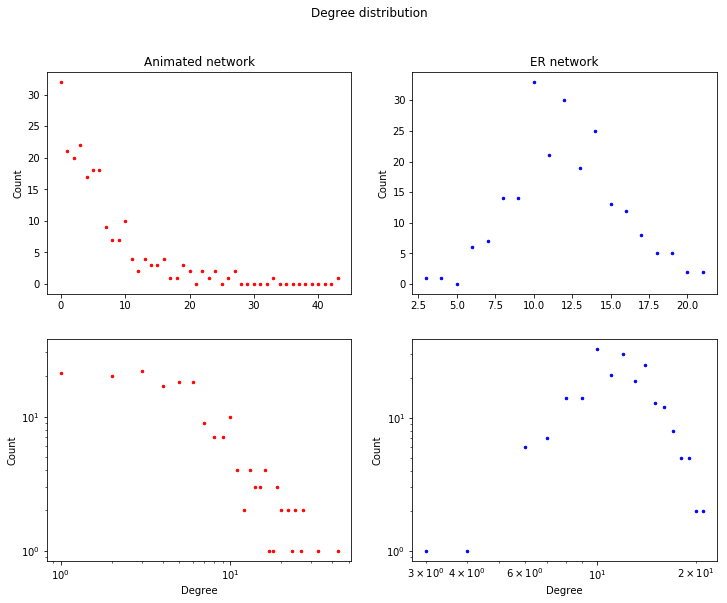

In [246]:
fig, axs = plt.subplots(2,2,figsize=(12,9))
fig.suptitle('Degree distribution ')
axs[0,0].title.set_text('Animated network')
axs[0,0].plot(bins1[:-1],hist1,'o',color='red', markersize=2.5)
axs[0,0].set_ylabel("Count")
axs[1,0].set_ylabel("Count")
axs[1,0].set_xlabel("Degree")
axs[1,0].loglog(bins1[:-1],hist1,'o', color='red', markersize=2.5)
axs[0,1].title.set_text("ER network")
axs[0,1].plot(bins3[:-1],hist3,'o',color='blue', markersize=2.5)
axs[0,1].set_ylabel("Count")
axs[1,1].set_ylabel("Count")
axs[1,1].set_xlabel("Degree")
axs[1,1].loglog(bins3[:-1],hist3,'o', color='blue', markersize=2.5)
plt.show()

We see that the first plot (upper left) has a long tail to the right, and to the left is few datapoints that dominate the counts. This distribution follows a power law and networks whose degree distribution follow a power law are Scale-free networks. When this distribution is on a double logarithmic axis it follows a straight line, which we also can confrim by looking at the plot lower-left corner. <br>
The ER network in plot upper-right corner follows the poisson distribution as expected. 

# 3. Tools, theory and analysis

This section focuses most on the analysis. We have divided it into a network analysis, where we are dividing the network into communities, a text analysis consisting of a TF-IDF analysis and a sentiment analysis.

## 3.1 Network analysis

To identify the communities in our network we use the Louvain algorithm on our undirected graph. <br>
The Louvain algorithm is a greedy modularity optimization method which contains two steps that are repeated iteratively. In step one the change in modularity for each node is calculated and the node will join the community with the neighbour who has the highest change in modularity. If no increase in modularity the node will remain in its original community. In step two the communities are merged into one node where links in the same community are represented as self loops. A new network is created and step one can be repeated. The algorithm will end when the maximum modularity is obtained. *(Network Science by Albert-László Barabási, section 9.c)*

In [101]:
partition = community.best_partition(UG)

In [137]:
node = [] 
Communities = []
for i in range(max(partition.values())+1):#Loop through the total number of communities
    for k in partition.keys():
        if partition[k]==i: #Finds all nodes in same community
            node.append(k)
    Communities.append(UG.subgraph(node)) #appending each subgraph for the communities
    node = []

In [82]:
print("The total number of communities found in the network is: "+ str(max(partition.values())+1))

The total number of communities found in the network is: 9


We will calculate the modularity. With the modularity we can see how good the partition is. The higher the value the better a partition.

In [104]:
def modularity(nc, L, kc, Lc):
    s=0
    for i in range(len(Lc)):
        c = ((Lc[i]/L)-(kc[i]/(2*L))**2)
        s = s + c
    print(s)

In [105]:
nc =max(partition.values())+1 #number of communities
L = DG.number_of_edges() #number of edges in the network
Lc=[] #list of number of edges in each community
kc =[] #list of degree in each community

for i in Communities: #loops through communities
    Lc.append(i.number_of_edges())

for i in Communities: #loops through communities
    s = 0
    for node in list(i.nodes):
        deg = i.degree(node)
        s=deg+s
    kc.append(s)
    s=0

In [106]:
print("Modularity for the partition is:")
modularity(nc, L, kc, Lc)

Modularity for the partition is:
0.4636175582990398


The modularity for the partition is 0.46, which is actually a very good partition in this case.

### 3.1.1 Community partition

We will visualize the distribution of the production studios in each community.

We make a list of lists containing the production studios of each node in the communities.

In [138]:
com = []
for i in Communities:
    l = []
    for j in list(i.nodes()):
        l.append(i.nodes()[j]['universe'])
    com.append(l)    

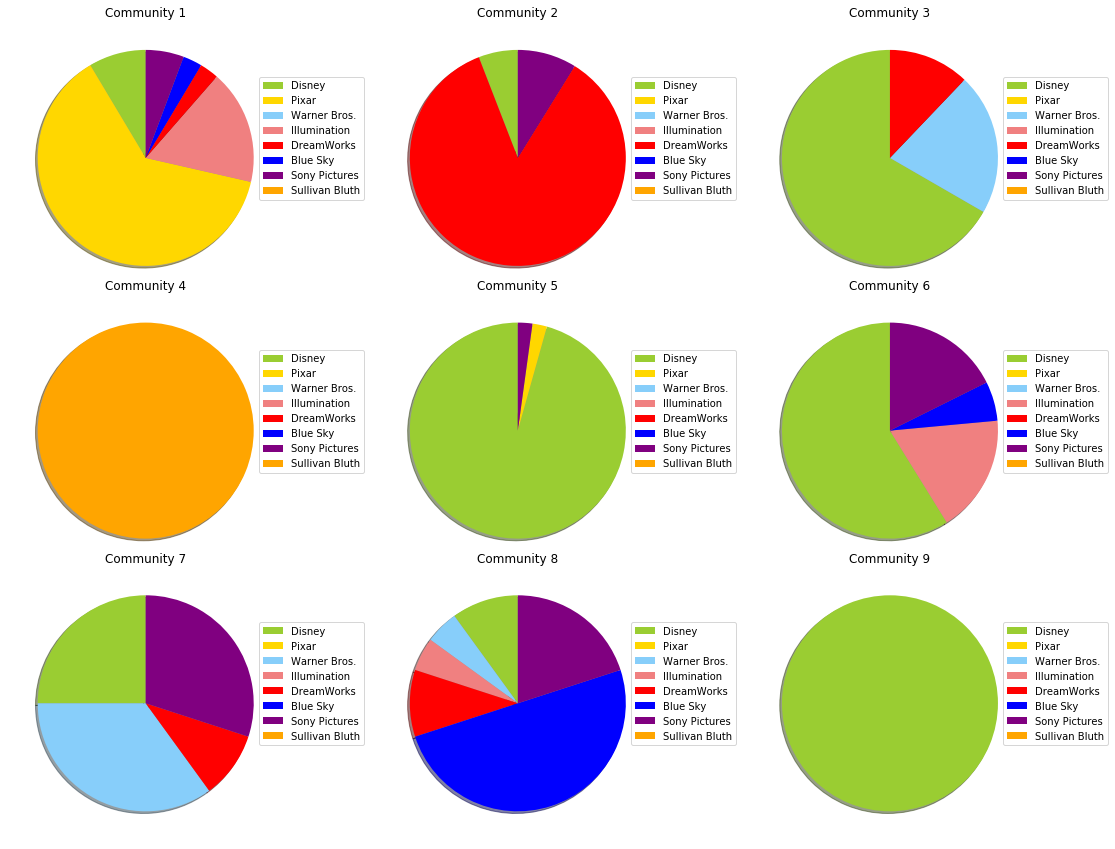

In [108]:
fig, axs = plt.subplots(3,3, figsize=(20, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .01, wspace=0.001)

axs = axs.ravel()

labels = ['Disney', 'Pixar', 'Warner Bros.', 'Illumination', 'DreamWorks', 'Blue Sky', 'Sony Pictures','Sullivan Bluth']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','red','blue','purple','orange']
    
for i in range(len(com)):
    sizes = [com[i].count('Disney'), com[i].count('Pixar'), com[i].count('Warner Bros. Animation productions'), com[i].count('Illumination'),com[i].count('DreamWorks'), com[i].count('Blue Sky'), com[i].count('Sony Pictures Animation productions'), com[i].count('Sullivan Bluth Studios')]
    axs[i].pie(sizes, colors=colors, shadow=True, startangle=90)
    axs[i].legend(labels,bbox_to_anchor=(0.92, 0.8), loc='upper left', borderaxespad=0.)
    #axs[i].legend(patches, labels, loc="best")
    axs[i].set_title(f"Community {i+1}")
    

The above pie charts show the division between movies from the different production studios in each community. In each community with exception of community 7 there is a majority of movies from one production studio. In community 1 is it Pixar, community 2 is it DreamWorks, community 3 and 6 is it Disney, community 4 only consists of Sullivan movies, community 5 almost only consists of Disney movies, community 8 is it Blue Sky and community 9 is it Warner Bros. Community 7 is a mix of Warner Bros, Disney, Sony and DreamWorks.  

Later we will dive into each community and see which movies they contain and try to see why the partition are made like it is.

### 3.1.2 Visualization of the network

In this visualization of the network the node color corresponds to the community and the nodesize are according to the production studio. We are adding a new nodeattribute to our network UG, which tells us which community the node belongs to.

In [109]:
#Adding new nodeattribute to network
dic = {}
for i in range(len(Communities)):
    for node in Communities[i]:
        dic[node] = {"community":i+1} 
        nx.set_node_attributes(UG, dic)

In [165]:
#Color map for each community
color_map = []
for n, d in UG.nodes(data=True):
    if d['community'] == 1:
        color_map.append("#ff0000") #red
    elif d['community'] == 2:
        color_map.append("#00ffff") #light blue
    elif d['community'] == 3:
        color_map.append("#ffc0cb") #light pink
    elif d['community'] == 4:
        color_map.append("#f8ff6b") #yellow
    elif d['community'] == 5:
        color_map.append("#735686") #purple
    elif d['community'] == 6:
        color_map.append("#215a30") #green
    elif d['community'] == 7:
        color_map.append("#97dc91") #light green
    elif d['community'] == 8:
        color_map.append("#11457f") #orange
    elif d['community'] == 9:
        color_map.append("#80bb18") #dusty green

We are scaling the nodesize according to the production studio. We are adding a new nodeattribute called 'category' where the node are given a number which we will use to scale the nodesize. 

In [166]:
#Adding a nodeattribute called "category" where the nodesize for each production studio are given
node_universe= nx.get_node_attributes(UG, 'universe')
dic1 = {}
for key in node_universe.keys():
    value =node_universe.get(key)
    if value== "Disney":
        dic1[key] = {"category":15} 
    elif value== "Pixar":
        dic1[key] = {"category":35}
    elif value== "Warner Bros. Animation productions":
        dic1[key] = {"category":55} 
    elif value== "Illumination":
        dic1[key] = {"category":75}
    elif value== "DreamWorks":
        dic1[key] = {"category":95} 
    elif value== "Blue Sky":
        dic1[key] = {"category":115}
    elif value== "Sony Pictures Animation productions":
        dic1[key] = {"category":135} 
    elif value== "Sullivan Bluth Studios":
        dic1[key] = {"category":155}
    nx.set_node_attributes(UG, dic1)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:22<00:00, 88.84it/s]


BarnesHut Approximation  took  8.91  seconds
Repulsion forces  took  12.90  seconds
Gravitational forces  took  0.06  seconds
Attraction forces  took  0.04  seconds
AdjustSpeedAndApplyForces step  took  0.28  seconds


C:\Users\jodth\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


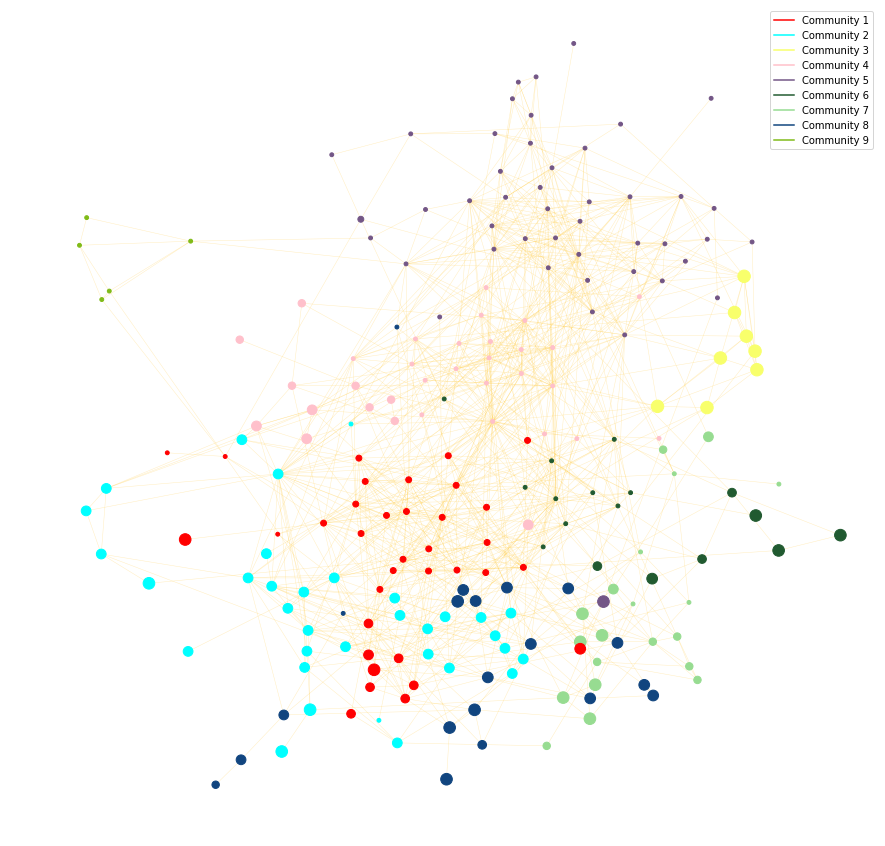

In [167]:
# Nodesize according to category
node_category= nx.get_node_attributes(UG, 'category')
node_size = [v for v in node_category.values()]

# Assign legends for each universe


forceatlas2 = ForceAtlas2(
                        #--> Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1,

                        #--> Performance
                        jitterTolerance=0.2,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.6,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        #--> Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        #--> Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(UG, pos=None, iterations=2000)

plt.figure(figsize=(15,15))
color_legend = {'Community 1': "#ff0000" , 'Community 2': "#00ffff", 'Community 3':"#f8ff6b", 'Community 4': "#ffc0cb", 'Community 5':"#735686", 'Community 6':"#215a30", 'Community 7':"#97dc91",'Community 8':"#11457f",'Community 9':"#80bb18"}
for label in color_legend:
    plt.plot([0],[0],color=color_legend[label],label=label)
plt.legend()
nx.draw_networkx_nodes(UG, positions, node_size=node_size, node_color=color_map)
nx.draw_networkx_edges(UG, positions, edge_color="#FFC733",alpha = 0.3,width= 0.5)
plt.axis('off')
plt.show()

### 3.1.3 Investigation of each community

Let us try to investigate the communities and see if we can find a connection between the movies. Off hand it looks like that most of the communities are divided such as the majority of the movies in the community are from the same production studio, though we see cases where it is a mix of productions studios, and on the same hand we are wondering why some movies from the same production studios are all alone in one community and some are together with other productions studioes. We will take a closer look at the movies in each community. 

#### Community 1

In [113]:
Data.loc[Data['Movie'].isin(list(Communities[0].nodes()))]

Movie                           Production  \
15                         Despicable Me                         Illumination   
18                       Despicable Me 2                         Illumination   
19                        Minions (film)                         Illumination   
20               The Secret Life of Pets                         Illumination   
22                       Despicable Me 3                         Illumination   
24             The Secret Life of Pets 2                         Illumination   
51                          Turbo (film)                           DreamWorks   
74                      Ferdinand (film)                             Blue Sky   
75               Open Season (2006 film)  Sony Pictures Animation productions   
83   Cloudy with a Chance of Meatballs 2  Sony Pictures Animation productions   
136                            Toy Story                                Pixar   
140                         A Bug's Life                                Pixar   
142                          Toy Story 2                                Pixar   
149                       Monsters, Inc.                                Pixar   
155                         Finding Nemo                                Pixar   
159                      The Incredibles                                Pixar   
161                       Valiant (film)                               Disney   
165                          Cars (film)                                Pixar   
167                   Ratatouille (film)                                Pixar   
169                               WALL-E                                Pixar   
172                       Up (2009 film)                                Pixar   
176                          Toy Story 3                                Pixar   
180                               Cars 2                                Pixar   
182                    Brave (2012 film)                                Pixar   
186                  Monsters University                                Pixar   
187                        Planes (film)                               Disney   
190                 Planes Fire & Rescue                               Disney   
194               Inside Out (2015 film)                                Pixar   
195                    The Good Dinosaur                                Pixar   
197                         Finding Dory                                Pixar   
199                               Cars 3                                Pixar   
200                     Coco (2017 film)                                Pixar   
201                        Incredibles 2                                Pixar   
203                          Toy Story 4                                Pixar   
207                        Onward (film)                                Pixar   

     Year  Budget   Gross  Profit (percent)  \
15   2010    69.0   543.0        686.956522   
18   2013    76.0   970.0       1176.315789   
19   2015    74.0  1159.0       1466.216216   
20   2016    75.0   875.0       1066.666667   
22   2017    80.0  1034.0       1192.500000   
24   2019    80.0   430.0        437.500000   
51   2013   127.0   283.0        122.834646   
74   2017   111.0   296.1        166.756757   
75   2006    85.0   200.0        135.294118   
83   2013    78.0   274.0        251.282051   
136  1995    30.0   374.0       1146.666667   
140  1998   120.0   363.3        202.750000   
142  1999    90.0   497.4        452.666667   
149  2001   115.0   577.4        402.086957   
155  2003    94.0   940.3        900.319149   
159  2004    92.0   633.0        588.043478   
161  2005    35.0    61.7         76.285714   
165  2006   120.0   462.0        285.000000   
167  2007   150.0   620.7        313.800000   
169  2008   180.0   533.3        196.277778   
172  2009   175.0   735.1        320.057143   
176  2010   200.0  1067.0        433.500000   
180  2011   200.0   562.1        181.

In community 1 we see that the majority of the movies are Pixar productions, so it makes sense that all of them are togehter. There are six Illumination movies we expect are connected, the question is how are these connect to the Pixar movies. 

In [134]:
UG.edges('Despicable Me')

EdgeDataView([('Despicable Me', 'Despicable Me 2'), ('Despicable Me', 'Despicable Me 3'), ('Despicable Me', 'Horton Hears a Who! (film)'), ('Despicable Me', 'Shrek Forever After'), ('Despicable Me', 'Toy Story 3'), ('Despicable Me', 'WALL-E'), ('Despicable Me', 'How to Train Your Dragon (film)'), ('Despicable Me', 'Megamind'), ('Despicable Me', 'Minions (film)'), ('Despicable Me', 'The Secret Life of Pets')])

From the above edgeview for the movie 'Despicable Me', we see that it is connected to all the other Illumination movies like expected. We see that it also connects to 'Toy Story 3', which we suspects is because they were released in the same year 2010. 

In [135]:
UG.edges('Planes (film)')

EdgeDataView([('Planes (film)', 'Cars (film)'), ('Planes (film)', 'Cars 2'), ('Planes (film)', 'Cloudy with a Chance of Meatballs 2'), ('Planes (film)', "Pooh's Heffalump Movie"), ('Planes (film)', 'Secret of the Wings'), ('Planes (film)', 'Planes Fire & Rescue'), ('Planes (film)', 'The Pirate Fairy')])

From the edgeview for 'Planes (film)' we see that it connects to 'Planes Fire & Rescue' which also was expected. At the same  time it connects to 'Cloudy with a Chance of Meatballs 2' which also can be because they were released in the same year 2013 and thereby was competing. 

In [137]:
UG.edges('Turbo (film)')

EdgeDataView([('Turbo (film)', 'Captain Underpants The First Epic Movie'), ('Turbo (film)', 'Cars (film)'), ('Turbo (film)', 'Despicable Me 2'), ('Turbo (film)', 'Monsters University'), ('Turbo (film)', 'Ratatouille (film)'), ('Turbo (film)', 'Rise of the Guardians')])

'Turbo (film)' is the only DreamWorks movie in the community, which we wondered about. But we see that it connects to 'Despicable Me 2' and 'Ratatouille (film)' which is also in the community. It makes sense that it connect to 'Despicable Me 2' since they were released in the same year, but 'Ratatouille (film)' were made six year before. We have checked the wikipedia page for 'Turbo (film)' and see that the connection is because that these two movies have similarities.

#### Community 2

In [114]:
Data.loc[Data['Movie'].isin(list(Communities[1].nodes()))]

Movie  \
25                                            Antz   
28                                     Chicken Run   
29                                           Shrek   
30                 Spirit Stallion of the Cimarron   
32                                         Shrek 2   
33                                      Shark Tale   
34                          Madagascar (2005 film)   
35   Wallace & Gromit The Curse of the Were-Rabbit   
36                           Over the Hedge (film)   
37                                    Flushed Away   
38                                 Shrek the Third   
39                                       Bee Movie   
40                                   Kung Fu Panda   
41                      Madagascar Escape 2 Africa   
42                             Monsters vs. Aliens   
43                 How to Train Your Dragon (film)   
44                             Shrek Forever After   
45                                        Megamind   
46                                 Kung Fu Panda 2   
47                       Puss in Boots (2011 film)   
48               Madagascar 3 Europe's Most Wanted   
49                           Rise of the Guardians   
50                                      The Croods   
53                      How to Train Your Dragon 2   
54                          Penguins of Madagascar   
55                                Home (2015 film)   
56                                 Kung Fu Panda 3   
60       How to Train Your Dragon The Hidden World   
61                          Abominable (2019 film)   
80   The Pirates! In an Adventure with Scientists!   
85                               Goosebumps (film)   
91                  Goosebumps 2 Haunted Halloween   
164                                       The Wild   
174                  A Christmas Carol (2009 film)   

                              Production  Year  Budget  Gross  \
25                            DreamWorks  1998    60.0  171.0   
28                            DreamWorks  2000    45.0  225.0   
29                            DreamWorks  2001    60.0  484.0   
30                            DreamWorks  2002    80.0  123.0   
32                            DreamWorks  2004   150.0  920.0   
33                            DreamWorks  2004    75.0  367.0   
34                            DreamWorks  2005    75.0  533.0   
35                            DreamWorks  2005    30.0  192.0   
36                            DreamWorks  2006    80.0  336.0   
37                            DreamWorks  2006   149.0  178.0   
38                            DreamWorks  2007   160.0  799.0   
39                            DreamWorks  2007   150.0  287.0   
40                            DreamWorks  2008   130.0  632.0   
41                            DreamWorks  2008   150.0  604.0   
42                            DreamWorks  2009   175.0  382.0   
43                            DreamWorks  2010   165.0  495.0   
44                            DreamWorks  2010   165.0  753.0   
45                            DreamWorks  2010   130.0  322.0   
46                            DreamWorks  2011   150.0  665.0   
47                            DreamWorks  2011   130.0  555.0   
48                            DreamWorks  2012   145.0  747.0   
49                            DreamWorks  2012   145.0  307.0   
50                            DreamWorks  2013   135.0  587.0   
53                            DreamWorks  2014   129.0  621.0   
54                            DreamWorks  2014   132.0  373.0   
55                            DreamWorks  2015   135.0  386.0   
56                            DreamWorks  2016   145.0  521.0   
60                            DreamWorks  2019   129.0  519.0   
61                            DreamWorks  2019    75.0  162.0   
80   Sony Pictures Animation productions  2012    55.0  123.0   
85   Sony Pictures Animation productions  2015    84.0  150.0   
91   Sony Pictures Animation productions  2018    35.0   93.0   
164      

In community 2 the majority of the movies are DreamWorks production, it makes sense that these movies are somehow connected. It is more interessting to look into why the three Sony movies and two Disney movies are in this community.

In [139]:
UG.edges('The Pirates! In an Adventure with Scientists!')

EdgeDataView([('The Pirates! In an Adventure with Scientists!', 'Brave (2012 film)'), ('The Pirates! In an Adventure with Scientists!', 'Flushed Away')])

In [140]:
UG.edges('Goosebumps (film)')

EdgeDataView([('Goosebumps (film)', 'Hotel Transylvania 2'), ('Goosebumps (film)', 'Shark Tale'), ('Goosebumps (film)', 'Shrek Forever After'), ('Goosebumps (film)', 'Goosebumps 2 Haunted Halloween')])

In [141]:
UG.edges('The Wild')

EdgeDataView([('The Wild', 'Dinosaur (film)'), ('The Wild', 'Finding Nemo'), ('The Wild', 'Lilo & Stitch'), ('The Wild', 'Madagascar (2005 film)'), ('The Wild', 'The Jungle Book (1967 film)'), ('The Wild', 'The Lion King')])

In [142]:
UG.edges('A Christmas Carol (2009 film)')

EdgeDataView([('A Christmas Carol (2009 film)', 'Monsters vs. Aliens')])

'The Pirates! In an Adventure with Scientists!' is a Sony production but it do not connect with other Sony movies, which is quite strange. By investigating the wikipedia page we see that there actually were another production studio in over the film which actually was the same production studio that made 'Flushed Away'. <br>
'Goosebumps (film)' are connected with 'Goosebumps 2 Haunted Halloween' and to other movies in the community. 'The Wild' shares plot with 'Madagascar (2005 film)' so it make sense for it to be mentioned at the wikipedia page. 'A Christmas Carol (2009 film)' only has one connection, so it would have been weird for this movie not to be at the same community as 'Monsters vs. Aliens'. These are connected because they were released in the same year 2009, and they were up for the same nomination.

#### Community 3

In [115]:
Data.loc[Data['Movie'].isin(list(Communities[2].nodes()))]

Movie  \
1                                  Space Jam   
2                           Cats Don't Dance   
3                          Quest for Camelot   
4                             The Iron Giant   
5                              Osmosis Jones   
6                Looney Tunes Back in Action   
11             Teen Titans Go! To the Movies   
26                       The Prince of Egypt   
27                     The Road to El Dorado   
31           Sinbad Legend of the Seven Seas   
52                     Mr. Peabody & Sherman   
130                  The Rescuers Down Under   
131         Beauty and the Beast (1991 film)   
132               Aladdin (1992 Disney film)   
133                            The Lion King   
134                            A Goofy Movie   
135                   Pocahontas (1995 film)   
137  The Hunchback of Notre Dame (1996 film)   
138                     Hercules (1997 film)   
139                        Mulan (1998 film)   
141                       Tarzan (1999 film)   
143                            Fantasia 2000   
145                          Dinosaur (film)   
146                 The Emperor's New Groove   
148                 Atlantis The Lost Empire   
151                            Lilo & Stitch   
152                          Treasure Planet   
156                             Brother Bear   
158            Home on the Range (2004 film)   
162               Chicken Little (2005 film)   
175                The Princess and the Frog   
204                The Lion King (2019 film)   
219                         Doug's 1st Movie   

                             Production  Year  Budget   Gross  \
1    Warner Bros. Animation productions  1996    80.0   230.4   
2    Warner Bros. Animation productions  1997    32.0     3.6   
3    Warner Bros. Animation productions  1998    40.0    38.1   
4    Warner Bros. Animation productions  1999    80.0    31.3   
5    Warner Bros. Animation productions  2001    70.0    14.0   
6    Warner Bros. Animation productions  2003    80.0    68.5   
11   Warner Bros. Animation productions  2018    10.0    52.1   
26                           DreamWorks  1998    70.0   218.0   
27                           DreamWorks  2000    95.0    76.0   
31                           DreamWorks  2003    60.0    81.0   
52                           DreamWorks  2014   145.0   276.0   
130                              Disney  1990     NaN    47.4   
131                              Disney  1991    25.0   440.1   
132                              Disney  1992    28.0   504.1   
133                              Disney  1994    45.0   968.5   
134                              Disney  1995     NaN    35.3   
135                              Disney  1995    55.0   346.1   
137                              Disney  1996   100.0   325.3   
138                              Disney  1997    85.0   252.7   
139                              Disney  1998    90.0   304.3   
141                              Disney  1999   130.0   448.2   
143                              Disney  2000    85.0    90.9   
145                              Disney  2000   127.5   349.8   
146                              Disney  2000   100.0   169.3   
148                              Disney  2001   120.0   186.1   
151                              Disney  2002    80.0   273.1   
152                              Disney  2002   140.0   109.6   
156                              Disney  2003    46.0   250.4   
158                              Disney  2004   110.0   145.5   
162                              Disney  2005   150.0   314.4   
175                              Disney  2009   205.0   270.0   
204                              Disney  2019   260.0  1657.0   
219                              Disney  1999     5.0    19.4   

     Profit (percent)                 RottenTomatoName  
1          188.000000                        space_jam  
2          -88.750000                  cats_dont_dance  
3           -4.750000   

In community 3 we have a lot of iconic and popular disney movies such as 'The Lion King', 'Beauty and the Beast (1991 film)' and 'Aladdin (1992 Disney film)', which are all made around at the same time. We also know that those movies has many links, so the other Disney movies must somehow be connected. In the community we also find a handfull Warner Bros. movies and four DreamWorks movies, which we will investigate further. We only look at some of them.

In [144]:
UG.edges('Sinbad Legend of the Seven Seas')

EdgeDataView([('Sinbad Legend of the Seven Seas', 'Aladdin (1992 Disney film)'), ('Sinbad Legend of the Seven Seas', 'Finding Nemo'), ('Sinbad Legend of the Seven Seas', 'Shrek'), ('Sinbad Legend of the Seven Seas', 'The Road to El Dorado')])

In [148]:
UG.edges('Mr. Peabody & Sherman')

EdgeDataView([('Mr. Peabody & Sherman', 'Home (2015 film)'), ('Mr. Peabody & Sherman', 'Beauty and the Beast (1991 film)'), ('Mr. Peabody & Sherman', 'The Lion King'), ('Mr. Peabody & Sherman', 'Penguins of Madagascar')])

By investigating 'Sinbad Legend of the Seven Seas' we see that it connects to Aladdin (1992 Disney film) which is because they share the same writer. 'Mr. Peabody & Sherman' also connects to the iconic movies 'Beauty and the Beast (1991 film)' and 'The Lion King'.

#### Community 4

In [116]:
Data.loc[Data['Movie'].isin(list(Communities[3].nodes()))]

Movie              Production  Year  Budget  Gross  \
94           The Secret of NIMH  Sullivan Bluth Studios  1982     7.0   14.7   
95             An American Tail  Sullivan Bluth Studios  1986     9.0   84.5   
96         The Land Before Time  Sullivan Bluth Studios  1988    12.0   84.5   
97        All Dogs Go to Heaven  Sullivan Bluth Studios  1989    13.8   27.1   
98                Rock-a-Doodle  Sullivan Bluth Studios  1992    18.0   11.7   
99      A Troll in Central Park  Sullivan Bluth Studios  1994     NaN   71.3   
100  The Pebble and the Penguin  Sullivan Bluth Studios  1995    28.0    3.9   
101                  Thumbelina  Sullivan Bluth Studios  1994    28.0   11.3   

     Profit (percent)         RottenTomatoName  
94         110.000000           secret_of_nimh  
95         838.888889         an_american_tail  
96         604.166667         land_before_time  
97          96.376812    all_dogs_go_to_heaven  
98         -35.000000            rock_a_doodle  
99                NaN  a-troll-in-central-park  
100        -86.071429   pebble_and_the_penguin  
101        -59.642857               thumbelina

Community 4 only consists of movies from Sullivan Bluth Studios, which are all made around the same time, so it make sense that they are in the same community.

#### Community 5

In [117]:
Data.loc[Data['Movie'].isin(list(Communities[4].nodes()))]

Movie  \
92                Spider-Man Into the Spider-Verse   
102    Snow White and the Seven Dwarfs (1937 film)   
103                          Pinocchio (1940 film)   
104                           Fantasia (1940 film)   
105                                          Dumbo   
106                                          Bambi   
107                                 Saludos Amigos   
108                           The Three Caballeros   
109                                Make Mine Music   
110                             Fun and Fancy Free   
111                                    Melody Time   
112         The Adventures of Ichabod and Mr. Toad   
113                         Cinderella (1950 film)   
114                Alice in Wonderland (1951 film)   
115                          Peter Pan (1953 film)   
116                             Lady and the Tramp   
117                    Sleeping Beauty (1959 film)   
118                 One Hundred and One Dalmatians   
119             The Sword in the Stone (1963 film)   
120                    The Jungle Book (1967 film)   
121                                 The Aristocats   
122                         Robin Hood (1973 film)   
123         The Many Adventures of Winnie the Pooh   
124                                   The Rescuers   
125                          The Fox and the Hound   
126                      The Black Cauldron (film)   
127                      The Great Mouse Detective   
128                               Oliver & Company   
129                 The Little Mermaid (1989 film)   
144                               The Tigger Movie   
150                           Return to Never Land   
153                              The Jungle Book 2   
154                             Piglet's Big Movie   
157                      Teacher's Pet (2004 film)   
160                         Pooh's Heffalump Movie   
163                                       Bambi II   
168                               Enchanted (film)   
208               The Reluctant Dragon (1941 film)   
210                              Song of the South   
211                            So Dear to My Heart   
212                            Mary Poppins (film)   
213                       Bedknobs and Broomsticks   
214                      Pete's Dragon (1977 film)   
215                        Who Framed Roger Rabbit   
217                           Mary Poppins Returns   
218  DuckTales the Movie Treasure of the Lost Lamp   

                              Production  Year   Budget   Gross  \
92   Sony Pictures Animation productions  2018   90.000  375.00   
102                               Disney  1937    1.500  418.00   
103                               Disney  1940    2.600  164.00   
104                               Disney  1940    2.300   80.00   
105                               Disney  1941    0.950    1.30   
106                               Disney  1942    0.860  267.40   
107                               Disney  1942      NaN    1.10   
108                               Disney  1944      NaN    3.40   
109                               Disney  1946    1.350    3.30   
110                               Disney  1947      NaN    3.20   
111                               Disney  1948    1.500    2.60   
112                               Disney  1949      NaN    1.60   
113                               Disney  1950    2.900  263.60   
114                               Disney  1951    3.000    5.60   
115                               Disney  1953    4.000   87.40   
116                               Disney  1955    4.000  187.00   
117                               Disney  1959    6.000   51.60   
118                               Disney  1961    3.600  303.00   
119                               Disney  1963    3.000   22.20   
120                               Disney  1967    4.000  378.00   
121                               Disney  1970    4.000  191.00   
122                             

Community 5 consists mostly of the older Disney movies. We have a few outliers such as 'Spider-Man Into the Spider-Verse' and 'Pooh's Heffalump Movie' which are Sony and Pixar productions.   

In [145]:
UG.edges('Spider-Man Into the Spider-Verse')

EdgeDataView([('Spider-Man Into the Spider-Verse', 'Cloudy with a Chance of Meatballs (film)'), ('Spider-Man Into the Spider-Verse', 'Hotel Transylvania 2'), ('Spider-Man Into the Spider-Verse', 'Mary Poppins Returns'), ('Spider-Man Into the Spider-Verse', 'Rise of the Guardians')])

In [146]:
UG.edges("Pooh's Heffalump Movie")

EdgeDataView([("Pooh's Heffalump Movie", 'Enchanted (film)'), ("Pooh's Heffalump Movie", 'Planes (film)'), ("Pooh's Heffalump Movie", "Piglet's Big Movie"), ("Pooh's Heffalump Movie", 'The Tigger Movie'), ("Pooh's Heffalump Movie", 'Winnie the Pooh (2011 film)')])

'Spider-Man Into the Spider-Verse' are in this community because it connects to 'Mary Poppins Returns', and that is because they were relased in the same year and was competing with each other. 'Pooh's Heffalump Movie' are the same Winnie the Pooh universe as 'Piglet's Big Movie' and 'The Tigger Movie'.

#### Community 6

In [118]:
Data.loc[Data['Movie'].isin(list(Communities[5].nodes()))]

Movie                           Production  Year  \
17              The Lorax (film)                         Illumination  2012   
21     Sing (2016 American film)                         Illumination  2016   
23             The Grinch (film)                         Illumination  2018   
69     Ice Age Continental Drift                             Blue Sky  2012   
79              Arthur Christmas  Sony Pictures Animation productions  2011   
88          The Star (2017 film)  Sony Pictures Animation productions  2017   
93       The Angry Birds Movie 2  Sony Pictures Animation productions  2019   
171             Bolt (2008 film)                               Disney  2008   
177                      Tangled                               Disney  2010   
181  Winnie the Pooh (2011 film)                               Disney  2011   
185               Wreck-It Ralph                               Disney  2012   
188           Frozen (2013 film)                               Disney  2013   
191            Big Hero 6 (film)                               Disney  2014   
196                     Zootopia                               Disney  2015   
198            Moana (2016 film)                               Disney  2016   
202    Ralph Breaks the Internet                               Disney  2018   
205                    Frozen II                               Disney  2019   

     Budget   Gross  Profit (percent)           RottenTomatoName  
17     70.0   348.0        397.142857             the_lorax_2012  
21     75.0   634.0        745.333333                  sing_2016  
23     75.0   511.0        581.333333                 the_grinch  
69     95.0   877.2        823.368421  ice_age_continental_drift  
79    100.0   147.0         47.000000           arthur_christmas  
88     20.0    85.0        325.000000              the_star_2017  
93     85.0   147.0         72.941176    the_angry_birds_movie_2  
171   150.0   310.0        106.666667                       bolt  
177   260.0   592.4        127.846154                    tangled  
181    30.0    50.1         67.000000       winnie_the_pooh_2011  
185   165.0   471.2        185.575758             wreck_it_ralph  
188   150.0  1280.0        753.333333                frozen_2013  
191   165.0   657.8        298.666667                 big_hero_6  
196   150.0  1024.0        582.666667                   zootopia  
198   175.0   690.8        294.742857                 moana_2016  
202   175.0   529.3        202.457143  ralph_breaks_the_internet  
205   150.0  1450.0        866.666667                  frozen_ii

Community 6 is a mix of different productions studios. The majority are Disney movies which in a sense are linked together.  

In [147]:
UG.edges("Arthur Christmas")

EdgeDataView([('Arthur Christmas', 'The Grinch (film)'), ('Arthur Christmas', 'The Star (2017 film)')])

In [148]:
UG.edges("Ice Age Continental Drift")

EdgeDataView([('Ice Age Continental Drift', 'Frozen (2013 film)'), ('Ice Age Continental Drift', 'Rio 2'), ('Ice Age Continental Drift', 'The Lorax (film)')])

In [150]:
UG.edges("Sing (2016 American film)")

EdgeDataView([('Sing (2016 American film)', 'Brave (2012 film)'), ('Sing (2016 American film)', 'Moana (2016 film)'), ('Sing (2016 American film)', 'Monsters vs. Aliens'), ('Sing (2016 American film)', 'The Grinch (film)')])

By looking at the links for few of the movies we can conclude that the movies are connected either bacuse they were released around the same time or they have some people involved in the movie in common. Eg. 'Frozen (2013 film)' and 'Moana (2016 film)' are connected because both of them resulted in an complete album.

#### Community 7

In [119]:
Data.loc[Data['Movie'].isin(list(Communities[6].nodes()))]

Movie  \
0                 Batman Mask of the Phantasm   
7                              The Lego Movie   
8                               Storks (film)   
9                       The Lego Batman Movie   
10                     The Lego Ninjago Movie   
12                           Smallfoot (film)   
13           The Lego Movie 2 The Second Part   
58                              The Boss Baby   
59    Captain Underpants The First Epic Movie   
77   Cloudy with a Chance of Meatballs (film)   
81                         Hotel Transylvania   
84                       Hotel Transylvania 2   
87                            The Emoji Movie   
89                        Peter Rabbit (film)   
90       Hotel Transylvania 3 Summer Vacation   
178                           Gnomeo & Juliet   
179                           Mars Needs Moms   
184                 Frankenweenie (2012 film)   
216          James and the Giant Peach (film)   
220            The Nightmare Before Christmas   

                              Production  Year  Budget  Gross  \
0     Warner Bros. Animation productions  1993     6.0    5.8   
7     Warner Bros. Animation productions  2014    60.0  469.2   
8     Warner Bros. Animation productions  2016    70.0  182.4   
9     Warner Bros. Animation productions  2017    80.0  310.1   
10    Warner Bros. Animation productions  2017    70.0  122.6   
12    Warner Bros. Animation productions  2018    80.0  212.2   
13    Warner Bros. Animation productions  2019    99.0  191.1   
58                            DreamWorks  2017   125.0  528.0   
59                            DreamWorks  2017    38.0  125.0   
77   Sony Pictures Animation productions  2009   100.0  243.0   
81   Sony Pictures Animation productions  2012    85.0  358.0   
84   Sony Pictures Animation productions  2015    80.0  475.0   
87   Sony Pictures Animation productions  2017    50.0  217.0   
89   Sony Pictures Animation productions  2018    50.0  351.0   
90   Sony Pictures Animation productions  2018    80.0  528.0   
178                               Disney  2010    36.0  193.9   
179                               Disney  2011   150.0   39.2   
184                               Disney  2012    39.0   81.5   
216                               Disney  1996    38.0   28.9   
220                               Disney  1993    18.0   91.4   

     Profit (percent)                           RottenTomatoName  
0           -3.333333                batman_mask_of_the_phantasm  
7          682.000000                             the_lego_movie  
8          160.571429                                     storks  
9          287.625000                      the_lego_batman_movie  
10          75.142857                     the_lego_ninjago_movie  
12         165.250000                                  smallfoot  
13          93.030303           the_lego_movie_2_the_second_part  
58         322.400000                              the_boss_baby  
59         228.947368    captain_underpants_the_first_epic_movie  
77         143.000000  1196077-cloudy_with_a_chance_of_meatballs  
81         321.176471                         hotel_transylvania  
84         493.750000                       hotel_transylvania_2  
87         334.000000                            the_emoji_movie  
89         602.000000                          peter_rabbit_2018  
90         560.000000       hotel_transylvania_3_summer_vacation  
178        438.611111                          gnomeo_and_juliet  
179        -73.866667                            mars_needs_moms  
184        108.974359                         frankenweenie_2012  
216        -23.947368                  james_and_the_giant_peach  
220        407.777778                 nightmare_before_christmas

In community 7 we again see a mix of production studios almost equally divided. 

In [155]:
UG.edges("Batman Mask of the Phantasm")

EdgeDataView([('Batman Mask of the Phantasm', 'The Lion King'), ('Batman Mask of the Phantasm', 'The Nightmare Before Christmas')])

In [152]:
UG.edges("The Boss Baby")

EdgeDataView([('The Boss Baby', 'Captain Underpants The First Epic Movie'), ('The Boss Baby', 'Lady and the Tramp')])

In [153]:
UG.edges("Hotel Transylvania")

EdgeDataView([('Hotel Transylvania', 'Frankenweenie (2012 film)'), ('Hotel Transylvania', 'Hotel Transylvania 2'), ('Hotel Transylvania', 'The Emoji Movie'), ('Hotel Transylvania', 'The Croods')])

In [154]:
UG.edges("Gnomeo & Juliet")

EdgeDataView([('Gnomeo & Juliet', 'Kung Fu Panda'), ('Gnomeo & Juliet', 'Mars Needs Moms'), ('Gnomeo & Juliet', 'The Lego Movie'), ('Gnomeo & Juliet', 'The Nightmare Before Christmas')])

In [156]:
UG.edges("James and the Giant Peach (film)")

EdgeDataView([('James and the Giant Peach (film)', 'The Nightmare Before Christmas')])

In [157]:
UG.edges("The Nightmare Before Christmas")

EdgeDataView([('The Nightmare Before Christmas', 'Batman Mask of the Phantasm'), ('The Nightmare Before Christmas', 'Enchanted (film)'), ('The Nightmare Before Christmas', 'Frankenweenie (2012 film)'), ('The Nightmare Before Christmas', 'Gnomeo & Juliet'), ('The Nightmare Before Christmas', 'Aladdin (1992 Disney film)'), ('The Nightmare Before Christmas', 'James and the Giant Peach (film)'), ('The Nightmare Before Christmas', 'Who Framed Roger Rabbit'), ('The Nightmare Before Christmas', 'Toy Story')])

In this community we see all the Lego movies, which of course makes sense that these are linked together. What we can see from the examples is that every one of them has at least one connection to another movie in the community. What is interesting is that we have three movies from 1990's where all the others are from 2010 and up. By investigation of those three movies we see that two of them connects to 'The Nightmare Before Christmas', and that movies has many other links. 

#### Community 8

In [120]:
Data.loc[Data['Movie'].isin(list(Communities[7].nodes()))]

Movie                           Production  Year  \
14                          Scoob!   Warner Bros. Animation productions  2020   
16                      Hop (film)                         Illumination  2011   
57                   Trolls (film)                           DreamWorks  2016   
62               Trolls World Tour                           DreamWorks  2020   
63             Ice Age (2002 film)                             Blue Sky  2002   
64              Robots (2005 film)                             Blue Sky  2005   
65            Ice Age The Meltdown                             Blue Sky  2006   
66      Horton Hears a Who! (film)                             Blue Sky  2008   
67   Ice Age Dawn of the Dinosaurs                             Blue Sky  2009   
68                 Rio (2011 film)                             Blue Sky  2011   
70                Epic (2013 film)                             Blue Sky  2013   
71                           Rio 2                             Blue Sky  2014   
72               The Peanuts Movie                             Blue Sky  2015   
73        Ice Age Collision Course                             Blue Sky  2016   
76                Surf's Up (film)  Sony Pictures Animation productions  2007   
78               The Smurfs (film)  Sony Pictures Animation productions  2011   
82                    The Smurfs 2  Sony Pictures Animation productions  2013   
86         Smurfs The Lost Village  Sony Pictures Animation productions  2017   
166             Meet the Robinsons                               Disney  2007   
192           Strange Magic (film)                               Disney  2014   

     Budget  Gross  Profit (percent)                       RottenTomatoName  
14     90.0   23.8        -73.555556                                  scoob  
16     63.0  184.0        192.063492                               hop_2011  
57    125.0  346.0        176.800000                                 trolls  
62    100.0   23.2        -76.800000                      trolls_world_tour  
63     59.0  383.3        549.661017                                ice_age  
64     75.0  260.7        247.600000                                 robots  
65     80.0  660.9        726.125000                              ice_age_2  
66     85.0  298.6        251.294118                 horton-hears-a-who2008  
67     90.0  886.0        884.444444  1194515-ice_age_dawn_of_the_dinosaurs  
68     90.0  484.6        438.444444                                    rio  
70     93.0  268.4        188.602151                              epic_2013  
71    103.0  498.8        384.271845                                  rio_2  
72     99.0  246.2        148.686869                      the_peanuts_movie  
73    105.0  408.6        289.142857               ice_age_collision_course  
76    100.0  149.0         49.000000                               surfs_up  
78    110.0  564.0        412.727273                             the_smurfs  
82    105.0  347.0        230.476190                           the_smurfs_2  
86     60.0  197.0        228.333333                smurfs_the_lost_village  
166     NaN  169.3               NaN                     meet_the_robinsons  
192   100.0   13.6        -86.400000                          strange_magic

In community 8 the majority are Blue Sky production movies, but this community is also a mix otherwise.

In [158]:
UG.edges("Scoob!")

EdgeDataView([('Scoob!', 'Trolls World Tour')])

In [159]:
UG.edges("Hop (film)")

EdgeDataView([('Hop (film)', 'Rio (2011 film)'), ('Hop (film)', 'Minions (film)'), ('Hop (film)', 'The Smurfs (film)')])

In [161]:
UG.edges("Strange Magic (film)")

EdgeDataView([('Strange Magic (film)', 'Epic (2013 film)'), ('Strange Magic (film)', 'Frozen (2013 film)'), ('Strange Magic (film)', 'Quest for Camelot'), ('Strange Magic (film)', 'Trolls (film)')])

By investigating only a few of the movies in the community we can se that the movies from different production studios connect by the year of release. 

#### Community 9

In [121]:
Data.loc[Data['Movie'].isin(list(Communities[8].nodes()))]

Movie Production  Year  Budget  \
170                            Tinker Bell (film)     Disney  2008    50.0   
173             Tinker Bell and the Lost Treasure     Disney  2009    35.0   
183                           Secret of the Wings     Disney  2012    35.0   
189                              The Pirate Fairy     Disney  2015     NaN   
193  Tinker Bell and the Legend of the NeverBeast     Disney  2015     NaN   

     Gross  Profit (percent)                              RottenTomatoName  
170    9.2        -81.600000                                   tinker_bell  
173    8.6        -75.428571             tinker_bell_and_the_lost_treasure  
183   67.5         92.857143                           secret_of_the_wings  
189   64.9               NaN                              the_pirate_fairy  
193   31.2               NaN  tinker_bell_and_the_legend_of_the_neverbeast

In [162]:
UG.edges("Tinker Bell (film)")

EdgeDataView([('Tinker Bell (film)', 'Return to Never Land'), ('Tinker Bell (film)', 'Peter Pan (1953 film)'), ('Tinker Bell (film)', 'Secret of the Wings'), ('Tinker Bell (film)', 'The Pirate Fairy'), ('Tinker Bell (film)', 'Tinker Bell and the Legend of the NeverBeast'), ('Tinker Bell (film)', 'Tinker Bell and the Lost Treasure')])

Community 9 is all Tinker Bell Disney movies who link to each other. These five movies almost only link to each other and that is why they have their own community. 

We can conclude according to our investigation that our communities are divided according to wikilinks of each movie. Those wikilinks can be because the movies are released around the same time, so they were competing or they can be from the same production studio or the same people can have made them.  

## 3.2 TF-IDF

This section consists of two parts - one where we calculate TF-IDF with text from the movies wikipedia pages and another where we are calculating TF-IDF with the text from the movie reviews. In both cases we will visualize it in our nine communities.

### 3.2.1 Wikipedia text

We have already downloaded all our wikipedia pages, so next step is to clean the text. We use the package *stopwords* to remove stopwords in the text. We have extended the stopword list with words that we do not want to take a closer look at because in our oppion they do not have a influence on the network or they are apart of the JSON load text.

In [163]:
stop_words = (stopwords.words('english')) #List of stopwords
#Adding more words to the list stop_words.
stop_words.extend(['br','www','http','ref','https','accessdate','date','org','com','would','url','wikipedia','wiki','also','cite','jpg','the','name','title','category','characters','character','creators','publisher','issue','web','vol','html','website','archiveurl','archivedate','nbsp','htm','january','february','march','april','may','june','july','august','september','october','november','december','new'])

We are making a list containing nine lists of the clean text for each community. We use regex code to remove [[]] from wikilinks. Furthermore we are removing *s and ed* from words, so we do not have two words which are the same but with different suffixs. We know that this also will effect words where s and ed are supposed to be there. We will keep that in mind when lokking at the wordclouds.

In [123]:
WordList=[]
for graph in Communities: #Loop through communities.
    word=[]
    for node in list(graph): #Loop through all the nodes in the subgraph
        ftext=open(f'./Movies/{node}.txt',encoding='utf-8').read() #Open download wiki page
        newText = re.sub(r'\[\[([^\|\]]+\|)?([^\]]+)\]\]',r'\2',ftext) #Remove [[]] around words
        words=re.findall(r"([\w'-]+)", newText) # Find all words in the wiki page
        newWords = [ch.lower() for ch in words if (ch.isalpha())] # Remove words containg punctuation and make the words lower case
        newWords1 = [ch1 for ch1 in newWords if ch1 not in stop_words] # Remove words that appear in the list stop_words.
        newWords2=[ch[:-1] if ch.endswith('s') else ch for ch in newWords1] 
        newWords3=[ch[:-1] if ch.endswith('ed') else ch for ch in newWords2] 
        word = newWords3 + word # Make a string with all the lower case words.
    WordList.append(word) # appending string with all the words in the community.

The TF is calulated for each word in each community. The used formula for TF is: $TF=\frac{f_{t,d}}{\text{number of words in}\space d}$. Where d = term (word) and d = documents. By using this formula we get a weigth independent of the document length which means that we can compare the same word in two documents with different lengths. 


We make a function *TF* that takes in a list of all the words in a community and return a list of the word, the word frequency and the TF value. This list is sorted by the TF value.

In [83]:
def TF(liste):
    DictMovies={}
    Dict1=dict(nltk.FreqDist(liste)) #Find frequency of each word 
    for k in Dict1.keys():
        w=Dict1[k]/len(liste) # Calculate TF
        DictMovies[k]=[Dict1[k],w] # Add frequency and TF value to dictionary
    sort_dict = sorted(DictMovies.items(), key=lambda x: x[1][1], reverse=True) #Sort dictionary by TF value
    return sort_dict 

Calculating TF-values for each community.

In [125]:
TFList=[]
for i in range(len(WordList)):
    TFList.append(TF(WordList[i])) # Appending the TF values for each community

To calulate IDF we first need a list of all distinct words in the communities.

In [126]:
UsedWords=[]
for i in range(len(WordList)):
    UsedWords.extend(WordList[i]) # list of all words.
UniqueWords=set(UsedWords)

The IDF value for each word is calcuted and put into a dictionary. The formula for calculating IDF-values is $IDF=\log \left( \frac{N}{n_t+1} \right) + 1.$ Where $N$ is the total number of documents and $n_t$ how many documents the word appears in. The reason for choosing this formula is that we still want to take words that appear in every document into account and not just set them equal to zero.

In [127]:
DictIDF={}
N=len(Communities) # number of documents
for word in UniqueWords:
    c=0 # count for how many documents a word appear in
    for i in range(len(WordList)):
        if word in (WordList[i]): # Check if word is in a document 
            c=c+1 #Upadate count
    idf=math.log(N/(c+1))+1 # Calculate IDF
    DictIDF[word]=[word,idf] # Dictionary with word and IDF

Now the TF-IDF value for every word in our communities can be calculated. This is done by the function *TFIDF* where the input is the list containing the word and TF value and the dictionary with the unique words and IDF value. The function returns a dictionary with the output *\[word, frequency, TF value, TF-IDF value\]*  

In [84]:
def TFIDF(liste,dict2):
    dict1=dict(liste) # Make TF-list to dictionary
    for word in dict1.keys():
        tfidf=dict1[word][1]*dict2[word][1] # Calculate TF-IDF
        dict1[word]=[dict1[word],tfidf] # Update dictionary
    return dict1

Calculating TF-IDF values

In [129]:
TFIDFList=[]
for i in range(len(TFList)):
    TFIDFList.append(TFIDF(TFList[i],DictIDF)) #List with all values

#### 3.2.1.1 Wordclouds

We would like to make a wordcloud for each community displaying the TF-IDF value. The bigger a value the bigger will the word be. We are making a list containing nine lists (one for each community) where all words and their TF-IDF value appear.

In [130]:
MovieWords=[]
for i in range(len(TFIDFList)):
    stringMovie = "" #Make an empty string
    for k in range (len(list(TFIDFList[i].keys()))):
        string1 = (list(TFIDFList[i].keys())[k]+" ")*int(TFIDFList[i][list(TFIDFList[i].keys())[k]][1]*10000) # Make a string with each word appear x times
        stringMovie = string1 + stringMovie
    MovieWords.append(stringMovie) #Appending the strings 

Making the wordcloud

In [131]:
wordcloud=[]
for i in range(len(MovieWords)):
    fig = WordCloud(width = 800, height = 800, background_color ='white', collocations = False, 
                min_font_size = 10).generate(MovieWords[i])
    wordcloud.append(fig) #Appending the wordcloud to a list

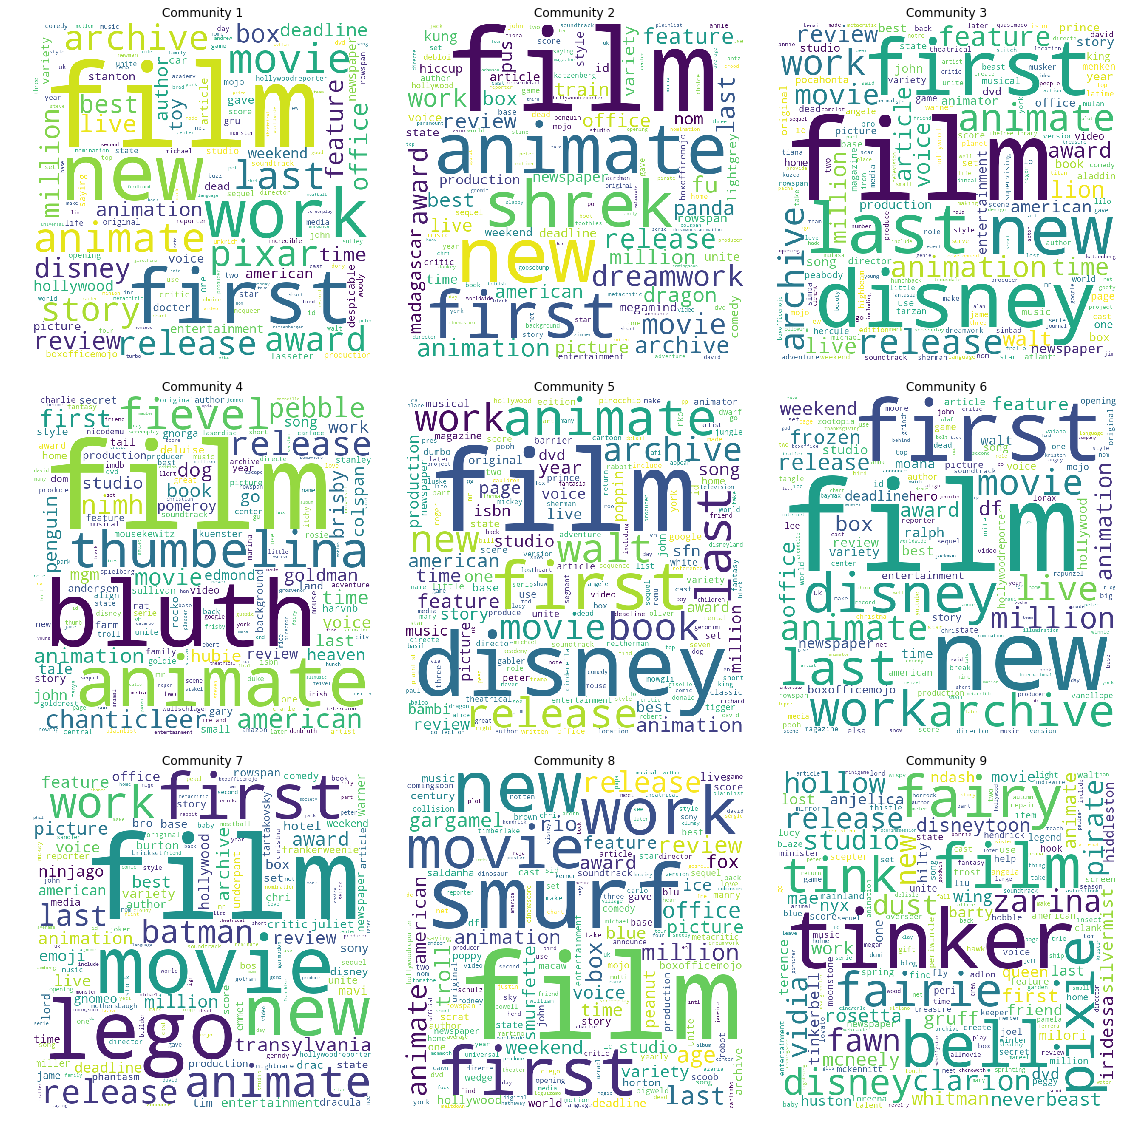

In [132]:
fig, axs = plt.subplots(3,3, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0.00001)

axs = axs.ravel()
    
for i in range(len(Communities)):
    axs[i].imshow(wordcloud[i])
    axs[i].set_title(f"Community {i+1}")
    axs[i].set_axis_off()

At first sight the nine wordclouds look like each other. They all for example have the words 'film', 'release', 'first', 'animate' and 'new'. If we dive a bit further we see that it is actually possible to seperate them from each other. Community 1 has words as 'disney', 'pixar', 'toy' and 'story', so it is actually possible from the wordcloud to see that this community has many pixar movies among Toy Story movies. In community 2 we see words such as 'shrek', 'dreamworks', 'madagascar' and 'panda'. In community 3 words such as 'disney', 'lion', 'king', 'song' and 'aladdin' appears. In community 4 words such as 'thumbelina', 'pebble', and 'bluth' appears which again are movies in the community and the production studio. In community 5 we have words such as 'disney', 'bambi', 'million', 'walt'. It is not that easy to see which movies that are in community 5 besides that they are Disney movies. In community 6 we see words such as 'disney', 'frozen', 'million and 'movie'. Again it is not that easy to tell which movies besides from Frozen that are in community 6. In community 7 words such as 'lego', 'batman' and 'transylvania' appears, which are very definite for community 7. In community 8 the words 'smurf', 'gargamel', 'horton' and 'scoob' appears. These words are also very definite for community 8. Lastly community 9 where we see words such as 'tinker', 'bell', 'disney', 'fairy' and 'pirate'. As in the two last communities these words are also very definitive for community 9 since it only consists of Tinker Bell movies. 

### 3.2.2 Review text

Earlier we have downloaded and cleaned all the movie reviews. They are stored in the dictionary called *ReviewDict*.

Like before we are making a list containing nine lists (one for each community) of words in the movie reviews.

In [14]:
WordListReview=[]
for graph in Communities: #Loop through communities.
    word=[]
    for node in list(graph):#Loop through all the nodes in the subgraph
        word = ReviewDict[node][3] + word
    merged = list(itertools.chain(*word)) #making a list of the list in list
    WordListReview.append(merged) # appending string with all the words in the community.

We are using the same functions as defined above for calculating TF and TF-IDF.

In [17]:
TFListReview=[]
for i in range(len(WordListReview)):
    TFListReview.append(TF(WordListReview[i])) # Appending the TF values for each community

In [18]:
UsedWordsReview=[]
for i in range(len(WordListReview)):
    UsedWordsReview.extend(WordListReview[i]) # list of all words.
UniqueWordsReview=set(UsedWordsReview)

In [19]:
DictIDFReview={}
N=len(Communities) # number of documents
for word in UniqueWordsReview:
    c=0 # count for how many documents a word appear in
    for i in range(len(WordListReview)):
        if word in (WordListReview[i]): # Check if word is in a document 
            c=c+1 #Upadate count
    idfReview=math.log(N/(c+1))+1 # Calculate IDF
    DictIDFReview[word]=[word,idfReview] # Dictionary with word and IDF

In [22]:
TFIDFListReview=[]
for i in range(len(TFListReview)):
    TFIDFListReview.append(TFIDF(TFListReview[i],DictIDFReview)) #List with all values

#### 3.2.2.1 Wordclouds

The wordclouds are made the same way as the ones with the wikipedia text.

In [23]:
MovieWordsReview=[]
for i in range(len(TFIDFListReview)):
    stringMovie = "" #Make an empty string
    for k in range (len(list(TFIDFListReview[i].keys()))):
        string1 = (list(TFIDFListReview[i].keys())[k]+" ")*int(TFIDFListReview[i][list(TFIDFListReview[i].keys())[k]][1]*10000) # Make a string with each word appear x times
        stringMovie = string1 + stringMovie
    MovieWordsReview.append(stringMovie) #Appending the strings 

In [24]:
wordcloudReview=[]
for i in range(len(MovieWordsReview)):
    fig = WordCloud(width = 800, height = 800, background_color ='white', collocations = False, 
                min_font_size = 10).generate(MovieWordsReview[i])
    wordcloudReview.append(fig) #Appending the wordcloud to a list

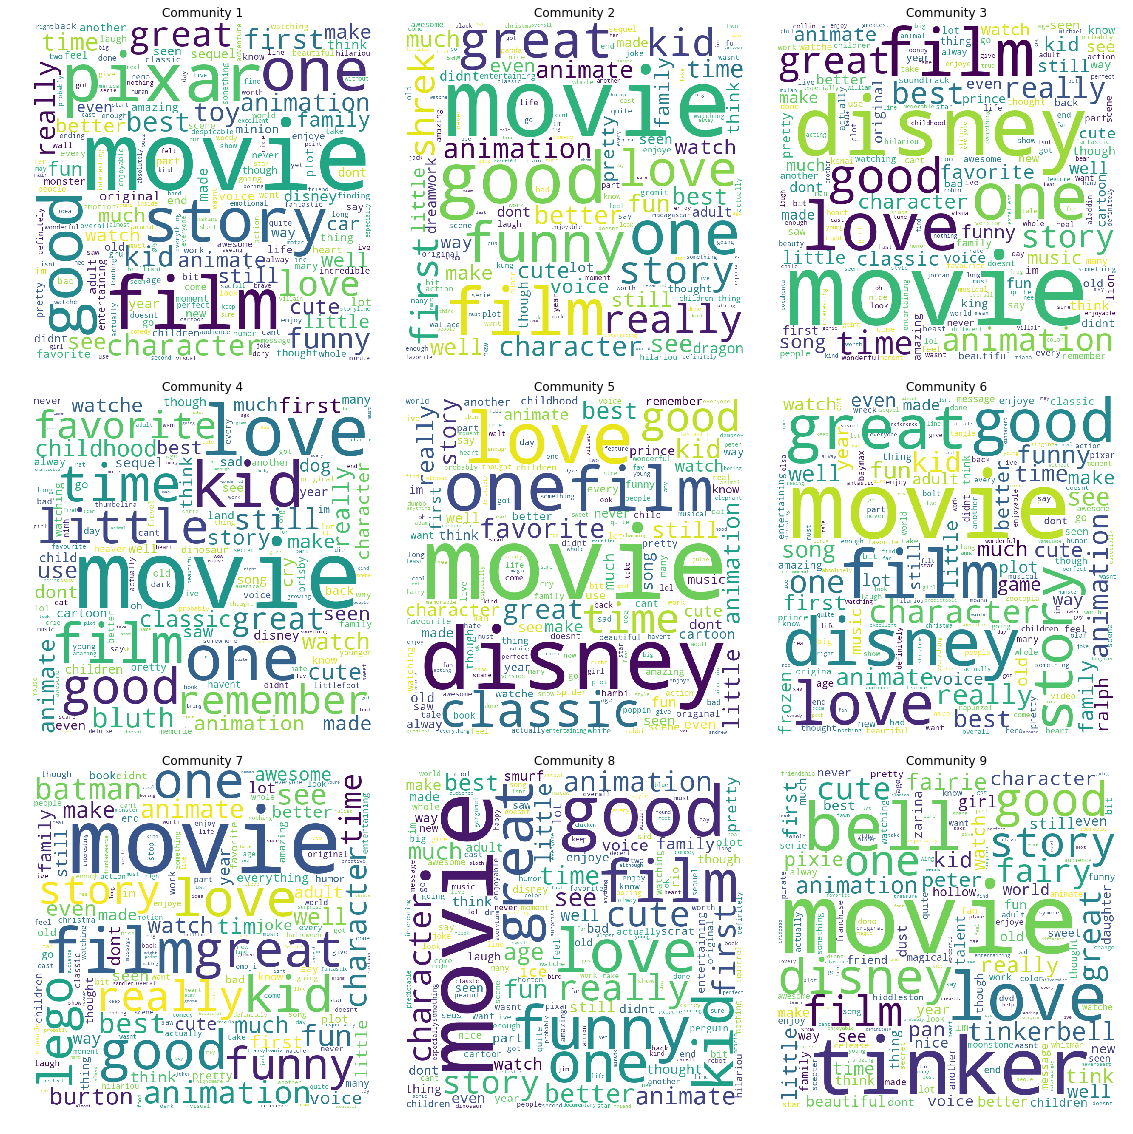

In [25]:
fig, axs = plt.subplots(3,3, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0.00001)

axs = axs.ravel()
    
for i in range(len(Communities)):
    axs[i].imshow(wordcloudReview[i])
    axs[i].set_title(f"Community {i+1}")
    axs[i].set_axis_off()

Again in these wordcloud we see words such as 'movie', 'love', 'great', 'good' and 'really' in all communities though in different sizes. For example the movies must be more funny in community 2 than in community 1, since the word 'funny' appears bigger in community 2 than in 1. Overall the wordclouds are very positive, so in general the reviews uses mostly positive words. We still see that the majority of the movies in community 1 are Pixar movies and in community 3, 5 and 6 the majority are Disney movies. In community 9 it is also very clear that Tinker Bell movies are in this community.    

## 3.3 Sentiment analysis

In this section we will calculate sentiment on the cleaned reviews. We will look at sentiment on each individual movie and also how the sentiment looks like in the communities, production studios and the 250 best reviews and 250 worst reviews.

We first download the LabMT wordlist from Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter. Here each word is ranked with a happiness_average.

In [197]:
table = pd.read_csv('labMT.txt', sep=" ")
table.head()

word  happiness_rank  happiness_average  happiness_standard_deviation  \
0   laughter               1               8.50                        0.9313   
1  happiness               2               8.44                        0.9723   
2       love               3               8.42                        1.1082   
3      happy               4               8.30                        0.9949   
4    laughed               5               8.26                        1.1572   

  twitter_rank google_rank nyt_rank lyrics_rank  
0         3600          --       --        1728  
1         1853        2458       --        1230  
2           25         317      328          23  
3           65        1372     1313         375  
4         3334        3542       --        2332

We define a function that calculate sentiment. It takes in a list and return a number.

In [198]:
def sentimentscore(liste):
    value=[]
    sums=[]
    list1=dict(nltk.FreqDist(liste))
    for word in list1.keys():
        if word in list(table['word']):
            c=table['happiness_average'][list(table['word']).index(word)]*list1[word]
            value.append(c)
            sums.append(list1[word])
    if len(value)>0:
        return sum(value)/sum(sums)
    else:
        return 0

For every movie the sentiment score is calculated and added to the dictionary ReviewDict.

In [201]:
for name in Data.Movie.values:
    string=[]
    for review in ReviewDict[name][3]:
        for word in review:
            string.append(word)
    Sentiment_Score=sentimentscore(string)
    ReviewDict[name]=[ReviewDict[name][0],ReviewDict[name][1],ReviewDict[name][2],ReviewDict[name][3], Sentiment_Score]

### 3.3.1 Distribution of sentiment

In [102]:
sentiment=[]
for name in Data.Movie.values:
    sentiment.append(ReviewDict[name][4])

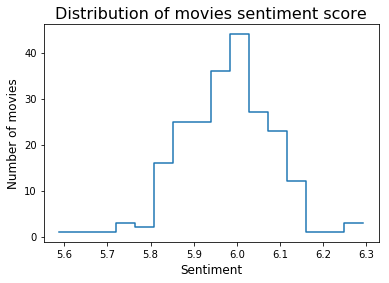

In [105]:
hist, bins = np.histogram(sentiment, bins = 'auto')

plt.figure(figsize=(6,4))
plt.plot(bins, np.insert(hist, 0, hist[0]), drawstyle='steps')
plt.title("Distribution of movies sentiment score", size=16)
plt.xlabel("Sentiment",size=12)
plt.ylabel("Number of movies",size=12)
plt.show()

The sentiment score seems to follow a normal distribution around 6. All of the values is between 5.5 and 6.5 which indicates that none of the movies has a very bad or good score. The average sentiment of the movies indicates that all the good and bad reviews balance each other out. However we are still interested in finding the movies with the highest and the lowest sentiment score.

### 3.3.2 Best and worst movies based on sentiment

We sort the dictionary by the sentiment score to be able to extract the best and the worst movies.

In [218]:
sort_sentiment = sorted(ReviewDict.items(), key=lambda x: x[1][4], reverse=True)

In [220]:
print("Best 10 movies by sentiment score\n")
print(tabulate([(sort_sentiment[i][0],ReviewDict[sort_sentiment[i][0]][4],ReviewDict[sort_sentiment[i][0]][2],len(ReviewDict[sort_sentiment[i][0]][0]),Data['Production'][list(Data['Movie']).index(sort_sentiment[i][0])]) for i in range (0, 10)], headers=["Movie", "Sentiment", "Average score","Number of reviews","Production studio"]))

Best 10 movies by sentiment score

Movie                        Sentiment    Average score    Number of reviews  Production studio
-------------------------  -----------  ---------------  -------------------  -----------------------------------
Abominable (2019 film)         6.29304          4.49292                 2260  DreamWorks
The Secret Life of Pets 2      6.27456          4.26433                 5200  Illumination
Shrek 2                        6.24955          3.83047                10010  DreamWorks
Spies in Disguise              6.21803          4.32817                 1970  Blue Sky
The Star (2017 film)           6.18048          4.17407                  270  Sony Pictures Animation productions
The Angry Birds Movie 2        6.14527          4.09534                 1180  Sony Pictures Animation productions
A Goofy Movie                  6.14446          3.69578                 6510  Disney
Lady and the Tramp             6.14327          3.88007                10010  Disney
T

In [221]:
print("Worst 10 movies by sentiment score\n")
print(tabulate([(sort_sentiment[-i][0],ReviewDict[sort_sentiment[-i][0]][4],ReviewDict[sort_sentiment[-i][0]][2],len(ReviewDict[sort_sentiment[-i][0]][0]),Data['Production'][list(Data['Movie']).index(sort_sentiment[-i][0])]) for i in range (1, 11)], headers=["Movie", "Sentiment", "Average score","Number of reviews","Production studio"]))

Worst 10 movies by sentiment score

Movie                               Sentiment    Average score    Number of reviews  Production studio
--------------------------------  -----------  ---------------  -------------------  -----------------------------------
Victory Through Air Power (film)      5.58804          3.25                      10  Disney
The Emoji Movie                       5.6679           2.63699                 3544  Sony Pictures Animation productions
Shark Tale                            5.71978          2.95                      10  DreamWorks
The Black Cauldron (film)             5.72149          3.11167                 1200  Disney
Ice Age Collision Course              5.72381          2.42092                  588  Blue Sky
Bambi                                 5.73494          3.50549                10010  Disney
Mars Needs Moms                       5.79736          2.96053                  950  Disney
Valiant (film)                        5.80624          2.9042

The best movie are 'Abominable (2019 film)' with a sentiment of 6.29 and the worst is 'Victory Through Air Power (film)' with a sentiment of 5.59. The one calculated the worst are actually removed from the network since it did not have any links. We do see a small tendency when the sentiment are high the average user score are high as well. Let us try to plot it and see if the trend is visible.

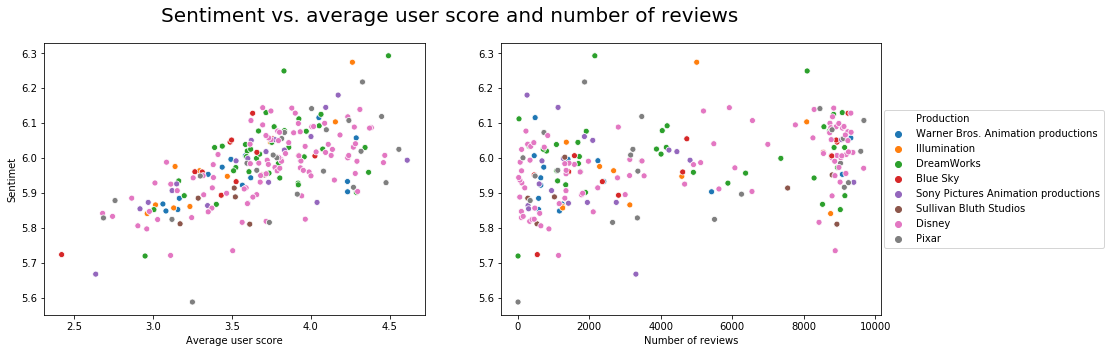

In [142]:
score_plot = [value[2] for value in ReviewDict.values()]
sentiment_plot = [value[4] for value in ReviewDict.values()]
review_plot = [len(value[3]) for value in ReviewDict.values()]

fig, axes= plt.subplots(nrows=1, ncols=2, squeeze=False,figsize=(15,5))
p1=sns.scatterplot(x=score_plot, y=sentiment_plot, data=Data, hue="Production",ax=axes[0][0],legend=False);
p1.set(ylabel='Sentimet')
p1.set(xlabel='Average user score')
p2=sns.scatterplot(x=review_plot, y=sentiment_plot, data=Data, hue="Production",ax=axes[0][1])
plt.suptitle("Sentiment vs. average user score and number of reviews",size=20)
p2.legend(loc='right', bbox_to_anchor=(1.6, 0.5), ncol=1)
p1.set(ylabel='Sentimet')
p2.set(xlabel='Number of reviews')
plt.show()

So we do see a clear trend in the sentiment vs. average user score. When the sentiment are high the average user score are as well. That do make good sense that it is like that, since positive words have a better happiness average than negative words. We are assuming that rating the movie good they have been using positive words in the reviews. <br>
We see no trend in the sentiment vs. number og reviews.

### 3.3.3 Sentiment in communities

In this section we will calculate the sentiment of each community. 

In [224]:
ComDict={}
i=1
for graph in Communities:
    sentiment_list=[]
    for node in graph.nodes():
        sentiment_list.append(reviews[node][4])
    ComDict["Community "+str(i)]=[mean(sentiment_list)]
    i=i+1

In [225]:
ComDict

{'Community 1': [5.980468479629944],
 'Community 2': [5.977837580781883],
 'Community 3': [5.9931226884410185],
 'Community 4': [5.915795333380313],
 'Community 5': [5.968005418695769],
 'Community 6': [6.021397516922342],
 'Community 7': [5.94833838781004],
 'Community 8': [5.977050329288156],
 'Community 9': [5.99424547923569]}

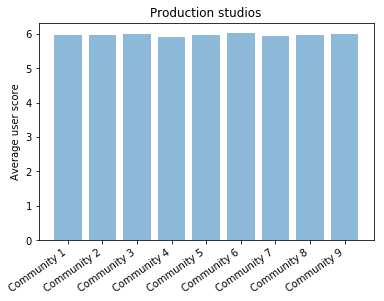

In [226]:
objects = ComDict.keys()
y_pos = np.arange(len(objects))
performance = [value[0] for value in ComDict.values()]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects,rotation=35,ha='right')
plt.ylabel('Sentiment')
plt.title('Production studios')

plt.show()

The sentiment of each community are very equal to each other. It is not possible to seperate them from each other. Each community has both movies that has a good and a bad sentiment which is balancing the sentiment. 

### 3.3.4 Sentiment in production studios

In this section we will calculate the sentiment of each production studio.

In [229]:
SentimentProduction={}
for production in Data.Production.unique():
    score=[]
    for movie in Data.loc[Data['Production'] == production]['Movie']:
        score.append(ReviewDict[movie][4])
    SentimentProduction[production]=[mean(score),len(score)]

In [235]:
SentimentProduction

{'Warner Bros. Animation productions': [5.950403377635276, 15],
 'Illumination': [5.990377217083584, 10],
 'DreamWorks': [6.003761946654823, 38],
 'Blue Sky': [5.992819262920795, 13],
 'Sony Pictures Animation productions': [5.975991116325226, 19],
 'Sullivan Bluth Studios': [5.915795333380313, 8],
 'Disney': [5.969832662523967, 95],
 'Pixar': [5.985459630290755, 23]}

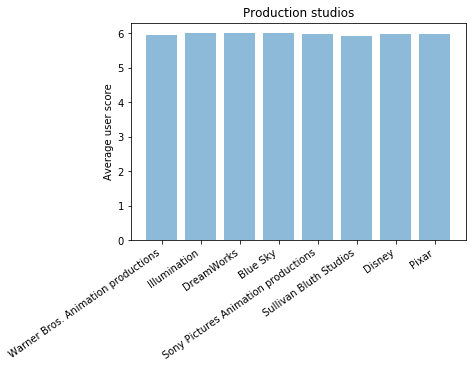

In [237]:
objects = SentimentProduction.keys()
y_pos = np.arange(len(objects))
performance = [value[0] for value in SentimentProduction.values()]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects,rotation=35,ha='right')
plt.ylabel('Sentiment')
plt.title('Production studios')

plt.show()

We see the same case when looking at the production studios as in the communities. There are both movies with good and bad reviews which balances the sentiment.

### 3.3.5 Sentiment vs. year, budget and gross

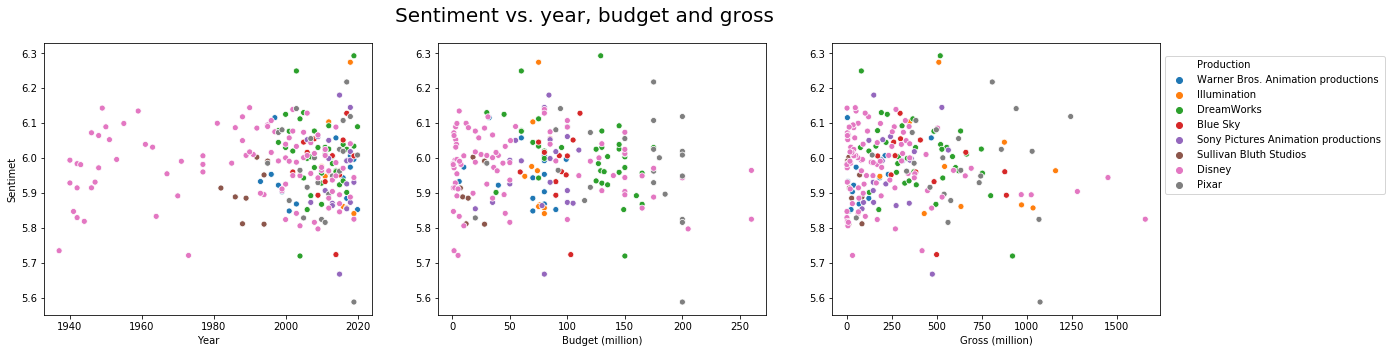

In [143]:
year_plot = [year for year in Data['Year']]
budget_plot = [b for b in Data['Budget']]
gross_plot = [g for g in Data['Gross']]


fig, axes= plt.subplots(nrows=1, ncols=3, squeeze=False,figsize=(20,5))
p1=sns.scatterplot(x=year_plot, y=sentiment_plot, data=Data, hue="Production",ax=axes[0][0],legend=False);
p1.set(ylabel='Sentimet')
p1.set(xlabel='Year')
p2=sns.scatterplot(x=budget_plot, y=sentiment_plot, data=Data, hue="Production",ax=axes[0][1],legend=False)
plt.suptitle("Sentiment vs. year, budget and gross",size=20)
p2.set(xlabel='Budget (million)')
p3=sns.scatterplot(x=gross_plot, y=sentiment_plot, data=Data, hue="Production",ax=axes[0][2],);
p3.set(xlabel='Gross (million)')
p3.legend(loc='right', bbox_to_anchor=(1.7, 0.7), ncol=1)
plt.show()




We see no trend between sentiment and the year of release, budget or gross. 

### 3.3.6 Top250 and bottom250 reviews based on sentiment

In this section we will analyze the 250 best reviews and the 250 worst reviews based on sentiment. We first make a dictionary with all cleaned reviews and their sentiment as values and the moviename added a number per review as keys.

In [3]:
SenDict={}
for movie in Data.Movie.values:
    i=0
    for review in ReviewDict[movie][3]:
        SenDict[movie +str(i)]=[movie,sentimentscore(review),ReviewDict[movie][3][i],i]
        i=i+1

Some reviews get a sentiment of zero, which we do not want to take into account. These are removed.

In [4]:
#Removing reviews that has sentiment zero
for key in list(SenDict.keys()):
    if SenDict[key][1]==0:
        del SenDict[key]

Let us first have a look at the distribution of sentiment of the cleaned reviews.

In [5]:
l=[]
for review in SenDict.keys():
    l.append(SenDict[review][1])

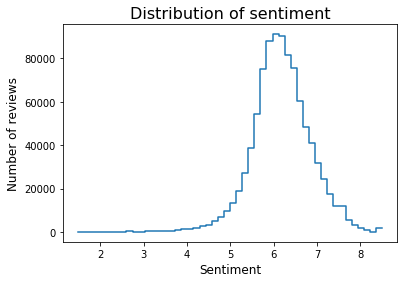

In [101]:
hist, bins = np.histogram(l, bins = 50)

plt.figure(figsize=(6,4))
plt.plot(bins, np.insert(hist, 0, hist[0]), drawstyle='steps')
plt.title("Distribution of sentiment", size=16)
plt.xlabel("Sentiment",size=12)
plt.ylabel("Number of reviews",size=12)
plt.show()

The distribution of sentiment seems to be normal distributed around 6. 

We are sorting the dictionary so we can extract the best and worst reviews.

In [11]:
sort = sorted(SenDict.keys(), key=lambda x: SenDict[x][1], reverse=True)

First we extract the 3 best movies.

In [49]:
#Top3 reviews
sort[0:3]

['Minions (film)3015',
 'Wallace & Gromit: The Curse of the Were-Rabbit6399',
 'Shrek the Third7307']

The three best reviews are review number 3015 for the movie 'Minions (film)', review numbber 6399 for the movie 'Wallace & Gromit: The Curse of the Were-Rabbit' and review number 7307 for movie 'Shrek the Third'. <br>
To be able to find the not cleaned review we have to manually look the reviews through. First we print the cleaned reviews.

In [44]:
print("Top3 best cleaned reviews:")
print('Minions (film): ' + str(ReviewDict['Minions (film)'][3][3015]))
print('Wallace & Gromit The Curse of the Were-Rabbit: ' + str(ReviewDict['Wallace & Gromit The Curse of the Were-Rabbit'][3][6399]))
print('Shrek the Third: ' + str(ReviewDict['Shrek the Third'][3][7307]))

Top3 best cleaned reviews:
Minions (film): ['laughter']
Wallace & Gromit The Curse of the Were-Rabbit: ['crie', 'laughter']
Shrek the Third: ['watche', 'fd', 'loudest', 'laughter']


Now we are manually looking through the not cleaned reviews where the words for the cleaned reviews appear. We have chosen not to include the code for this manually lookup. We will just print the movie and the review found.

In [45]:
print("Top3 best reviews:")
print('Minions (film): ' + str(ReviewDict['Minions (film)'][0][3228]))
print('Wallace & Gromit The Curse of the Were-Rabbit: ' + str(ReviewDict['Wallace & Gromit The Curse of the Were-Rabbit'][0][7002]))
print('Shrek the Third: ' + str(ReviewDict['Shrek the Third'][0][8113]))

Top3 best reviews:
Minions (film): just more and more laughter
Wallace & Gromit The Curse of the Were-Rabbit: I cried with laughter!
Shrek the Third: Watched it with fd and I had the loudest laughter.....


It is not a surprise that that the three best reviews contain the word 'laughter', since it is the word with the highest happiness average og 8.5. 

Now we take a look at the 3 worst reviews.

In [50]:
#Bottom3 reviews
sort[-3:]

['The Lion King8660', 'The Incredibles7553', 'Inside Out (2015 film)3197']

The three worst reviews are review number 8660 for the movie 'The Lion King', review numbber 7553 for the movie 'The Incredibles' and review number 3197 for movie 'Inside Out (2015 film)'. It is quite interessting that both 'The Lion King' and 'The incredibles' are respectively rated high average user score and high sentiment score that these movies has the worst reviews. <br>
We are using the same manually method for finding the not cleaned reviews as above.

In [51]:
print("Bottom3 worst cleaned reviews:")
print('The Lion King: ' + str(ReviewDict['The Lion King'][3][8660]))
print('The Incredibles: ' + str(ReviewDict['The Incredibles'][3][7553]))
print('Inside Out (2015 film): ' + str(ReviewDict['Inside Out (2015 film)'][3][3197]))

Bottom3 worst cleaned reviews:
The Lion King: ['mufassa', 'death', 'hilariou']
The Incredibles: ['watche', 'death']
Inside Out (2015 film): ['wante', 'murder', 'sadnes']


In [52]:
print("Bottom3 worst reviews:")
print('The Lion King: ' + str(ReviewDict['The Lion King'][0][9880]))
print('The Incredibles: ' + str(ReviewDict['The Incredibles'][0][8893]))
print('Inside Out (2015 film): ' + str(ReviewDict['Inside Out (2015 film)'][0][3443]))

Bottom3 worst reviews:
The Lion King: Mufassa death = Hilarious
The Incredibles: watched it to death too
Inside Out (2015 film): I wanted to murder "Sadness".


We see that we actually in the worst reviews has a false negative since the review for 'The Incredibles' actually is a positive review since it means that the person watched the movie very much (because it was a good movie). 

#### 3.3.6.1 Wordclouds

We are making wordclouds for the 250 best reviews and 250 worst reviews using the same procedure as before. So we will not explain the code this time.

In [53]:
Top250=[]
for movie in sort[0:250]:
    for word in SenDict[movie][2]:
        Top250.append(word)

In [54]:
Bottom250=[]
for movie in sort[-251:]:
    for word in SenDict[movie][2]:
        Bottom250.append(word)

In [55]:
TotalReview=[Top250,Bottom250]

In [85]:
TFList250=[]
for i in range(len(TotalReview)):
    TFList250.append(TF(TotalReview[i])) # Appending the TF values for each community

In [88]:
UsedWords250=[]
for i in range(len(TotalReview)):
    UsedWords250.extend(TotalReview[i]) # list of all words.
UniqueWords250=set(UsedWords250)

In [89]:
DictIDF250={}
N=2 # number of documents
for word in UniqueWords250:
    c=0 # count for how many documents a word appear in
    for i in range(len(TotalReview)):
        if word in (TotalReview[i]): # Check if word is in a document 
            c=c+1 #Upadate count
    idf=math.log(N/(c+1))+1 # Calculate IDF
    DictIDF250[word]=[word,idf] # Dictionary with word and IDF

In [90]:
TFIDFList250=[]
for i in range(len(TFList250)):
    TFIDFList250.append(TFIDF(TFList250[i],DictIDF250)) #List with all values

In [91]:
ReviewWords=[]
for i in range(len(TFIDFList250)):
    stringMovie = "" #Make an empty string
    for k in range (len(list(TFIDFList250[i].keys()))):
        string1 = (list(TFIDFList250[i].keys())[k]+" ")*int(TFIDFList250[i][list(TFIDFList250[i].keys())[k]][1]*10000) # Make a string with each word appear x times
        stringMovie = string1 + stringMovie
    ReviewWords.append(stringMovie) #Appending the strings 

In [92]:
from wordcloud import WordCloud
wordcloud250=[]
for i in range(len(ReviewWords)):
    fig = WordCloud(width = 800, height = 800, background_color ='white', collocations = False, 
                min_font_size = 10).generate(ReviewWords[i])
    wordcloud250.append(fig) #Appending the wordcloud to a list

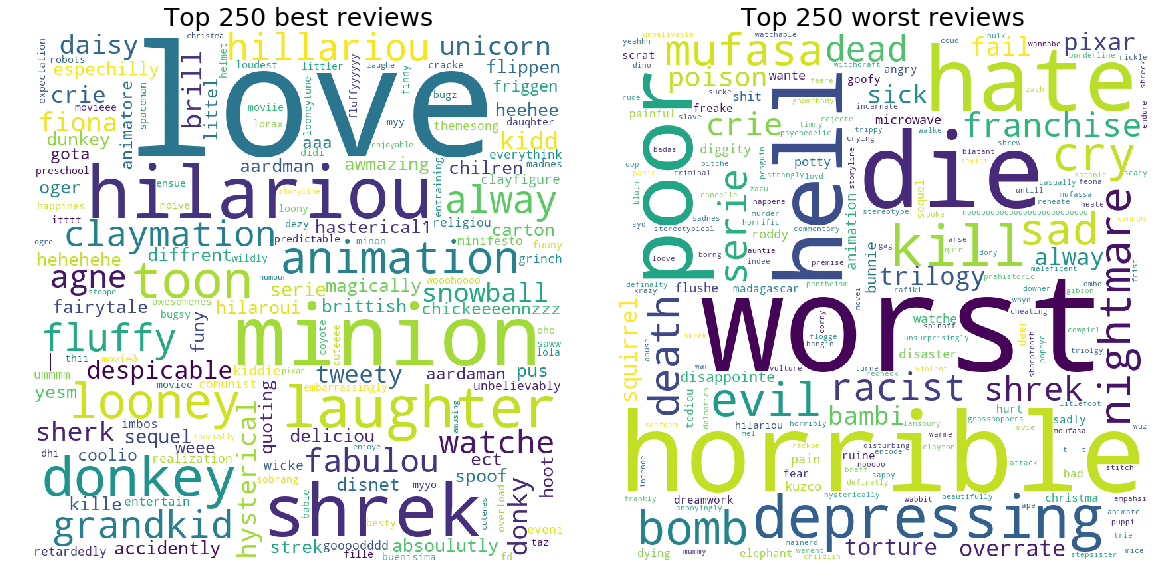

In [93]:
fig, axs = plt.subplots(1,2, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.1)

axs = axs.ravel()
    
axs[0].imshow(wordcloud250[0])
axs[0].set_title("Top 250 best reviews",size=25)
axs[0].set_axis_off()
axs[1].imshow(wordcloud250[1])
axs[1].set_title("Top 250 worst reviews",size=25)
axs[1].set_axis_off()

We clearly see a difference in the two wordclouds. It is clear to see that the 250 best reviews are using more positive words than the 250 worst reviews. In our cleaning we have removed 's' from the end of the words (also on words where it is actually wrong like the word hilarious). We also see that some words are misspelled which we have not taking into account. That is why the word 'hilarious' and 'hillarious' appears. We see 'Shrek' in both wordclouds, it can be because 'Shrek' has been giving both negative og positive reviews, but it can also be because words with a bad happiness average has been used in a positive way like 'I really liked that they killed the bad person, he was very annoying and deserved a horrible death', this would actually be kind of positive because it was something the person liked about the movie, but bacause there are so many words with a low happiness average it would get af bad sentiment. That we suspect are the case why 'mufasa' is in the wordcloud with bad reviews, bacuse people must in their reviews have written something like "It was very sad that Mufasa died". 
The wordcloud of 250 best reviews are using words such as 'love', 'fabulous', 'hilarious', 'fluffy', 'minion' and 'laugther' where the wordcloud of 250 worst reviews are using words such as 'worst', 'depressing', 'die', 'poor' and 'hate'. 

# 4. Discussion

Overall we think we have done a good job both with being exploratory about our basic statistics, understanding the network and about making network analysis with communities and sentiment of movie reviews. We did discover a correlation between sentiment and user score, which showed that the higher a sentiment the better user score. We did also succeed downloading moviereviews from Rotten Tomatos with a method that was not showed in the course. We are happy about the webpage we have created, which we think shows the most important parts of our explainer notebook. We did not have any experience of making a webpage before, so we think we have succeeded. 

We could have improved the analysis by looking at a way to have weigthed the edges, so it would be clear which connections were stronger. Maybe if a link was mentioned multiple times in the wikipedia page. It would also have been interesting looking at the network where links between two nodes would have been if they shared director, actor or sing-/songwriter. Maybe we could also have extended the network with more production studios, so the network was a bit bigger. Due to running time we chose only to extract around 10,000 reviews for each movie. With more time we could have extracted all reviews and it would have been more accurate. Furthermore we was not able to do wordclouds on the production studios (due to running time), by looking at the results for wordclouds for communities our conclusion is that it probably would not have showed any difference since each production studio has both good and bad movies so it wourld balance each other. It would have been interesting to do wordclouds on time, so the movies would have been divided into maybe a ten year interval.   

# 5. Contributions

This project has been a close cooperation between the groupmembers. Every subject and result have been discussed and analyzed together as well as we have helped each other with the parts. Signe has been primary responsible for downloading movie reviews from Rotten Tomato and for creating the webpage. Josefine has been primary responsible for downloading wikipediapages/-text and creating the network as well as creating the network analysis and explainer notebook. Basic stats and sentiment analysis have been a equal contribution from both of us. 